<a href="https://colab.research.google.com/github/rafaelespinosacastaneda/ClubesDeCiencia2025/blob/main/ClubesDeCiencias2025Xalapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diseño de experimentos


#### **Diseño Completamente Aleatorizado (CRD)**

* Es el diseño más simple, donde todas las ejecuciones experimentales se asignan de forma aleatoria.

* Asume homogeneidad entre las unidades experimentales.

**¿Cuándo usarlo?**

* Cuando todas las condiciones experimentales son uniformes.
* Cuando no existen factores de agrupación conocidos (como lotes u operadores) que afecten los resultados.


/tmp/ipython-input-1-259048640.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Tipo de electrolito", data=df_crd, palette="viridis")


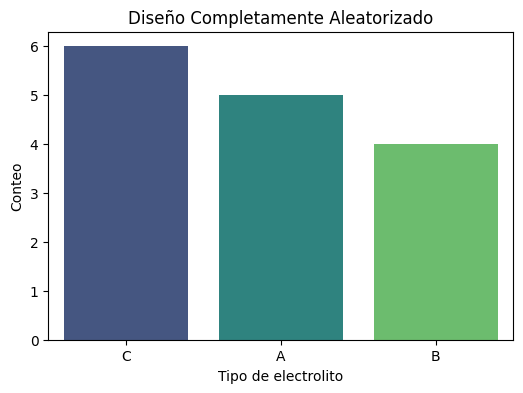

In [ ]:
# ejemplo
# Prueba de la estabilidad electroquímica de un nuevo electrolito para baterías.
# Factor: Composición del electrolito (A, B, C)
# Respuesta: Vida útil en ciclos (medida en ciclos de carga/descarga)

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Definir tratamientos (tipos de electrolito)

electrolitos = ['A', 'B', 'C']

# De forma aleatoria asigna muestras a los tratamientos
np.random.seed(403)  # Por reproducubilidad
samples = np.random.choice(electrolitos, size=15)  # 15  experimentos en total

df_crd = pd.DataFrame({'ID de muestra': range(1, 16), 'Tipo de electrolito': samples})

# Visualize distribution
plt.figure(figsize=(6,4))
sns.countplot(x="Tipo de electrolito", data=df_crd, palette="viridis")
plt.title("Diseño Completamente Aleatorizado")
plt.xlabel("Tipo de electrolito")
plt.ylabel("Conteo")
plt.show()


#### **Muestreo por Hipercubo Latino (Latin Hypercube Sampling)**

* Asegura que los puntos de muestreo cubran uniformemente todo el espacio de parámetros.
* Cada nivel del factor se muestrea sin repetición dentro de un rango particionado.
* Muestreo eficiente en espacios de alta dimensión.

**Ventajas y Desventajas**

✅ Eficiente para espacios de diseño de alta dimensión

✅ Asegura una buena cobertura de todos los niveles de los factores

❌ No está optimizado para efectos de interacción

**¿Cuándo usarlo?**

Cuando se prueban propiedades de materiales en un espacio amplio de parámetros.


In [ ]:
#---------------------------------------------Primero instala pydoe3 para que funcione el codigo --------------------------------

!pip install pydoe3

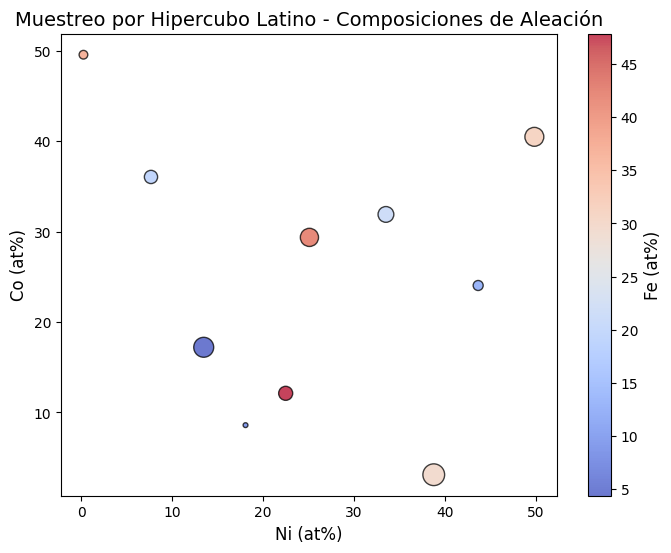

In [ ]:
# Ejemplo - Muestreo de composiciones de aleaciones de alta entropía (HEA) usando LHS.
# Factores: Ni, Co, Fe, Mn (cada uno varía de 0 a 50 at%)

from pyDOE3 import lhs

# Definir 4 elementos (Ni, Co, Fe, Mn) y muestrear 10 composiciones
num_muestras = 10
muestras_lhs = lhs(4, samples=num_muestras)  # Genera valores entre (0,1)

# Escalar al rango real de composiciones (0-50 at%)
rango_composicion = np.array([0, 50])
composiciones = muestras_lhs * (rango_composicion[1] - rango_composicion[0]) + rango_composicion[0]

df_lhs = pd.DataFrame(composiciones, columns=['Ni (at%)', 'Co (at%)', 'Fe (at%)', 'Mn (at%)'])

# Crear figura y gráfico de dispersión
plt.figure(figsize=(8, 6))
dispersión = plt.scatter(df_lhs["Ni (at%)"], df_lhs["Co (at%)"],
                         c=df_lhs["Fe (at%)"], cmap="coolwarm",
                         s=(df_lhs["Mn (at%)"] * 5), alpha=0.75, edgecolors="k")

# Añadir barra de color para Fe
barra_color = plt.colorbar(dispersión)
barra_color.set_label("Fe (at%)", fontsize=12)

# Títulos y etiquetas
plt.title("Muestreo por Hipercubo Latino - Composiciones de Aleación", fontsize=14)
plt.xlabel("Ni (at%)", fontsize=12)
plt.ylabel("Co (at%)", fontsize=12)

# Mostrar gráfico
plt.show()



#### Usar muestreo por hipercubo latino para generar parámetros de color


In [ ]:
import matplotlib.colors as mcolors
from scipy.stats import qmc
import pandas as pd

# Establecer parámetros
num_muestras = 25             # Número de muestras
suma_total = 300              # Restricción de la suma total
dimensiones = 3               # Dimensiones RYB (Rojo, Amarillo, Azul)
valor_mínimo = 10             # Valor mínimo para cada componente

# Asegurar límite superior factible
límite_superior = suma_total - (dimensiones - 1) * valor_mínimo

# Generar muestras LHS en el rango [0, 1]
muestreador = qmc.LatinHypercube(d=dimensiones, seed=0)
muestras_lhs = muestreador.random(n=num_muestras)

# Escalar a rango entero asegurando la restricción de suma
muestras_escaladas = np.floor(muestras_lhs * (límite_superior - valor_mínimo + 1) + valor_mínimo)

# Ajustar las sumas por fila para que sumen `suma_total`
muestras_ajustadas = np.round(
    muestras_escaladas / muestras_escaladas.sum(axis=1, keepdims=True) * suma_total
).astype(int)

# Asegurar que la corrección de suma no provoque valores menores al mínimo
for fila in muestras_ajustadas:
    while fila.sum() != suma_total:
        diferencia = suma_total - fila.sum()
        índice = np.random.choice(dimensiones)  # Elegir aleatoriamente un índice a ajustar
        if fila[índice] + diferencia >= valor_mínimo:
            fila[índice] += diferencia  # Ajustar con la diferencia

# Imprimir las muestras generadas
print(muestras_ajustadas)
print("Sumas por fila:", muestras_ajustadas.sum(axis=1))  # Todas deberían ser 300

# Separar los componentes R, Y y B
muestras_rojo = muestras_ajustadas[:, 0]
muestras_amarillo = muestras_ajustadas[:, 1]
muestras_azul = muestras_ajustadas[:, 2]


# Crear y guardar el DataFrame
df_colores = pd.DataFrame({'Rojo': muestras_rojo, 'Amarillo': muestras_amarillo, 'Azul': muestras_azul})
df_colores.to_csv('ColoresRafaelEspinosa.csv', index=False)

[[ 75  78 147]
 [ 99 190  11]
 [105 115  80]
 [213  18  69]
 [109 117  74]
 [129  88  83]
 [ 37  90 173]
 [ 75 154  71]
 [ 73 205  22]
 [ 25 190  85]
 [ 88 132  80]
 [216  46  38]
 [ 98 132  70]
 [113  85 102]
 [127  57 116]
 [100 134  66]
 [107  90 103]
 [230  10  60]
 [ 27 112 161]
 [ 24 152 124]
 [ 40  43 217]
 [ 55 114 131]
 [128  55 117]
 [ 85 106 109]
 [138  31 131]]
Sumas por fila: [300 300 300 300 300 300 300 300 300 300 300 300 300 300 300 300 300 300
 300 300 300 300 300 300 300]


# Imports y Funciones

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
!pip install gradio_client
from gradio_client import Client
import time
import json
import smtplib
import ssl
import ast
from email.message import EmailMessage

In [ ]:
def rfPredictionUncertainty(rf, xVal, percentile=90):
    """
    Funcion que calcula la prediccion de random forest y estima su incertidumbre.
    La estimacion de la incertidumbre es calculada tomando la diferencia entre
    la prediccion del percentil proporcionado y el (percentil proporcionado)/2 del random forest.
    Por default se calcula la incertidumbre con los percentiles 90 y 45.
    ----------
    rf : sklearn.ensemble.RandomForestRegressor
        El bosque aleatorio YA ENTRENADO a ser utilizado.

    xVal : pandas.DataFrame
        Features del validation set - datos sobre los cualese hara predicciones

    percentile : float, optional
        El perfecntil usado para el calculo de la incertidumbre. Default es 90.

    Funcion regresa
    -------
    y_mean : pandas.Series
        Promedio de las predicciones del modelo random forest

    y_uncert : pandas.Series
        Incertidumbre de las predicciones del modelo random forest
    """

    # initialize a list to hold the predictions from each tree
    y_preds = []
    # loop through the trees in the random forest
    for tree in rf_fitted.estimators_:
        # get the predictions from each tree
        y_pred = tree.predict(xVal)
        # append the predictions to the list
        y_preds.append(y_pred)
    # Convert to np.array by stacking list of arrays along the column axis with each column being the prediction from a different tree
    y_preds = np.stack(y_preds, axis=1)
    # get the quantiles for the confidence interval
    q_down = (100 - percentile) / 2.
    q_up = 100 - q_down

    # get the mean, uncertainty, lower bound, and upper bound
    y_lower = np.percentile(y_preds, q_down, axis=1)
    y_upper = np.percentile(y_preds, q_up, axis=1)
    y_mean = rf_fitted.predict(xVal)
    y_uncert = y_upper - y_lower

    return y_mean, y_uncert

In [ ]:
def validate_colors(r, y, b):
    """Esta funcion es para verificar que los volumenes de los colores esten correctos,
    en el experimento real usaran esta. Los valores deben estar en el rango mencionado (1-300 µL)."""
    if not all(1 <= v <= 300 for v in [r, y, b]):
        return "Volumen debe estar entre 1 y 300 µL."
    if r + y + b > 300:
        return "Volumen total excede los 300 µL de limite."
    return None

def send_email_notification(recipient_email, output_filename):
    sender_email = "mse403h@163.com"
    sender_password = "MQFUF4DM4eUaku6P"  # Use an App Password instead of your login password

    subject = "Experimentos completados"
    body = f"""Querido clubero,

Todos los experimentos que mandaste han sido completados exitosamente!.
Felicitaciones! Acabas de hacer experimentos en Canada desde Mexico!
Los experiemntos del robot que controlaste se encuentran agregados en un CSV en este mail.

Saludos,
Jose Manuel Barraza y Rafael Espinosa
"""

     # Crea mensaje
    msg = EmailMessage()
    msg["From"] = sender_email
    msg["To"] = recipient_email
    msg["Subject"] = subject
    msg.set_content(body)

    # Les pega el archivo csv
    with open(output_filename, "rb") as file:
        msg.add_attachment(file.read(), maintype="application", subtype="csv", filename=output_filename)

    # Manda el email
    try:
        context = ssl.create_default_context()
        with smtplib.SMTP_SSL("smtp.163.com", 465, context=context) as server:
            server.login(sender_email, sender_password)
            server.send_message(msg)

        print("\n📧 Email notification sent successfully!")
    except Exception as e:
        print(f"\n⚠️ Failed to send email: {e}")

def extract_data(row):
    """
    Esta funcion extrae la data del sensor"""
    command = ast.literal_eval(row['Command'])
    sensor_data = ast.literal_eval(row['Sensor Data'])
    return pd.Series({
        'R': command.get('R'),
        'Y': command.get('Y'),
        'B': command.get('B'),
        'Well': command.get('well'),
        **sensor_data
    })

# Esto es para acceder al cliente del SDL
client = Client("https://accelerationconsortium-ot-2-lcm.hf.space/")


def verify_student_id(student_id):
  '''Esta funcion les permite verificarse como usuarios del SDL en este caso deberan usar las credenciales que les proporcionemos'''
  try:
    result = client.predict(student_id, api_name="/verify_student_id")
    return result
  except Exception as e:
    print(f"Error de verificacion: {str(e)}")
    return None


def queue_status():
  """Esta funcion les da el status actual del SDL, que experimentos tiene en fila, que experimentos siguen"""
  try:
      queue_status = client.predict(
          api_name="/update_queue_display"
      )
      print(queue_status)

  except Exception as e:
          print(f"Error al intentar obtener el estatus: {str(e)}")


def validate_colors(r_vol,y_vol,b_vol):
  """Esta funcion es para validar que el punto que estan introduciendo no pase del volumen sugerido"""
  total_volume = r_volume + y_volume + b_volume
  if any(v < 1 or v > 300 for v in [r_volume, y_volume, b_volume]):
        print("Error: Each volume must be between 1 and 300 µL")
  elif total_volume > 300:
        print(f"Error: Total volumen ({total_volume}µL) excede los 300µL")
  else:
        print(f"Total volumen: {total_volume}µL - Valido!")

def submit_experiment(student_id, r_vol, y_vol, b_vol, info=True):
    """Esta funcion es para que suban su experimento, con errores corregidos."""
    result = None  # 1. Inicializamos result para evitar el UnboundLocalError
    try:
        # Validar los colores ANTES de enviar (recomendado)
        error_msg = validate_colors(r_vol, y_vol, b_vol)
        if error_msg:
            print(f"Experimento no enviado. {error_msg}")
            return None

        # Determinar el endpoint de la API
        api_endpoint = "/debug" if student_id == "debug" else "/submit"

        # Imprimir mensaje de espera solo si info es True
        if info:
            print(f"Enviando experimento a '{api_endpoint}'... Esperando resultados...")

        # Enviar el trabajo al cliente
        job = client.submit(
            student_id,
            r_vol,
            y_vol,
            b_vol,
            api_name=api_endpoint
        )
        result = job.result()

        # 2. Combinamos las acciones de 'info' en un solo bloque
        if info:
            print("Resultado recibido:")
            print(json.dumps(result, indent=2))
            print("\n✅ Experimento completado y procesado exitosamente!") # 3. Mensaje de éxito movido aquí

        return result

    except Exception as e:
        print(f"❌ Error durante la subida: {str(e)}")
        return None # Retorna None en caso de cualquier excepción

Loaded as API: https://accelerationconsortium-ot-2-lcm.hf.space/ ✔


# Experimentos:

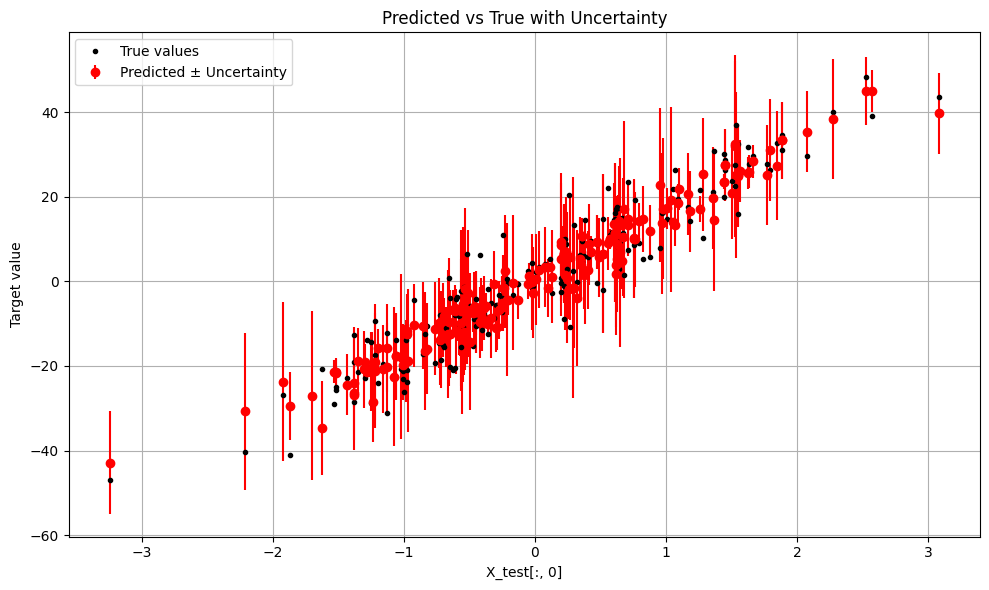

In [ ]:

#-------------------------------------- ESTA SECCION ES PARA GENERAR INCERTIDUMBRE Y PREDICCIONES PROMEDIO. SUSTITUYAN CON SUS CSV -----------------------------------------

from sklearn.datasets import make_regression
x, y = make_regression(n_samples=1000, n_features=1, noise=5.5, random_state=42)

#-------------------------------------- ----------------------------------------------------------------------------- -----------------------------------------
# Dividimos los datos en datos de entrenamiento y datos de testeo
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Creamos el modelo de Random Forest con 100 arboles
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenamos el modelo
rf_fitted = rf.fit(x_train, y_train)

#  Obtenemos las predicciones (means- promedio de los arboles en el random forest ) y sus incertidumbres
means, uncertainties=rfPredictionUncertainty(rf_fitted, x_test)

# Graficamos los datos reales de testeo, las predicciones y sus incertidumbres
plt.figure(figsize=(10, 6))
plt.errorbar(x_test, means, yerr=uncertainties, fmt='ro', label='Predicted ± Uncertainty')
plt.plot(x_test, y_test, 'k.', label='True values')
plt.xlabel('X_test[:, 0]')
plt.ylabel('Target value')
plt.title('Predicted vs True with Uncertainty')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Funciones de adquisicion


In [ ]:
#Probability of Improvement
from scipy.stats import norm

def probabilidad_mejora(x, modelo, mejor_objetivo, xi=0.01):
    """
    Calcula la Probabilidad de Mejora (Probability of Improvement, PI) en los puntos X.

    Parámetros:
    -----------
    X : np.ndarray, forma (n_muestras, n_características)
        Puntos donde se calculará la PI.
    modelo : modelo entrenado con .predict(X, return_std=True)
        Por ejemplo, un GaussianProcessRegressor de sklearn o gpflow.
    mejor_objetivo : float
        El mejor valor observado de la función objetivo.
    xi : float, opcional
        Margen de mejora considerado (por defecto 0.01).

    Retorna:
    --------
    pi : np.ndarray, forma (n_muestras,)
        Probabilidad de mejora en cada punto X.
    """
    media, desviacion = rfPredictionUncertainty(modelo,X_denso)


    desviacion = desviacion.reshape(-1)  # Asegura vector 1D

    with np.errstate(divide='warn'):
        Z = (media - mejor_objetivo - xi) / desviacion
        pi = norm.cdf(Z)
        pi[desviacion == 0.0] = 0.0  # Maneja desviación cero

    return pi

In [ ]:
#Expected improvement (Mejora esperada)

from scipy.stats import norm

def mejora_esperada(x, modelo, mejor_objetivo, xi=0.01):
    """
    Calcula la Mejora Esperada (Expected Improvement, EI) en los puntos X.

    Parámetros:
    -----------
    X : np.ndarray, forma (n_muestras, n_características)
        Puntos donde se calculará la EI.
    modelo : un modelo entrenado con .predict(X, return_std=True)
        Típicamente un GaussianProcessRegressor de sklearn o gpflow.
    mejor_objetivo : float
        El mejor valor observado de la función objetivo hasta el momento.
    xi : float, opcional
        Parámetro que controla la exploración vs. explotación (por defecto 0.01).

    Retorna:
    --------
    mejora_esp : np.ndarray, forma (n_muestras,)
        Mejora esperada en cada punto de X.
    """
    media, desviacion =  rfPredictionUncertainty(modelo, x)
    desviacion = desviacion.reshape(-1)  # Asegura que sea un vector 1D

    with np.errstate(divide='warn'):
        mejora = media - mejor_objetivo - xi
        Z = mejora / desviacion
        mejora_esp = mejora * norm.cdf(Z) + desviacion * norm.pdf(Z)
        mejora_esp[desviacion == 0.0] = 0.0  # Maneja desviación cero

    return mejora_esp

In [ ]:
def upper_confidence_bound(x, modelo, kappa=1.96):
    """
    Calcula el Límite Superior de Confianza (Upper Confidence Bound, UCB).

    Parámetros:
    -----------
    x : np.ndarray, forma (n_muestras, n_características)
        Puntos candidatos donde se calculará el UCB.
    modelo : un modelo entrenado (ej. RandomForestRegressor)
        El modelo debe ser compatible con la función auxiliar que extrae
        media y desviación (como rfPredictionUncertainty).
    kappa : float, opcional
        Parámetro que controla la exploración vs. explotación. Un valor más
        alto favorece la exploración (por defecto 1.96, que corresponde al 95%).

    Retorna:
    --------
    ucb : np.ndarray, forma (n_muestras,)
        Puntuación UCB para cada punto en x.
    """
    #Obteniendo media e incertidumbre
    media, desviacion = rfPredictionUncertainty(modelo, x)
    desviacion = desviacion.reshape(-1)  # Asegura que sea un vector 1D

    # La fórmula UCB es directa: media + kappa * desviacion
    ucb = media + kappa * desviacion

    return ucb

# Active Learning Loop

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


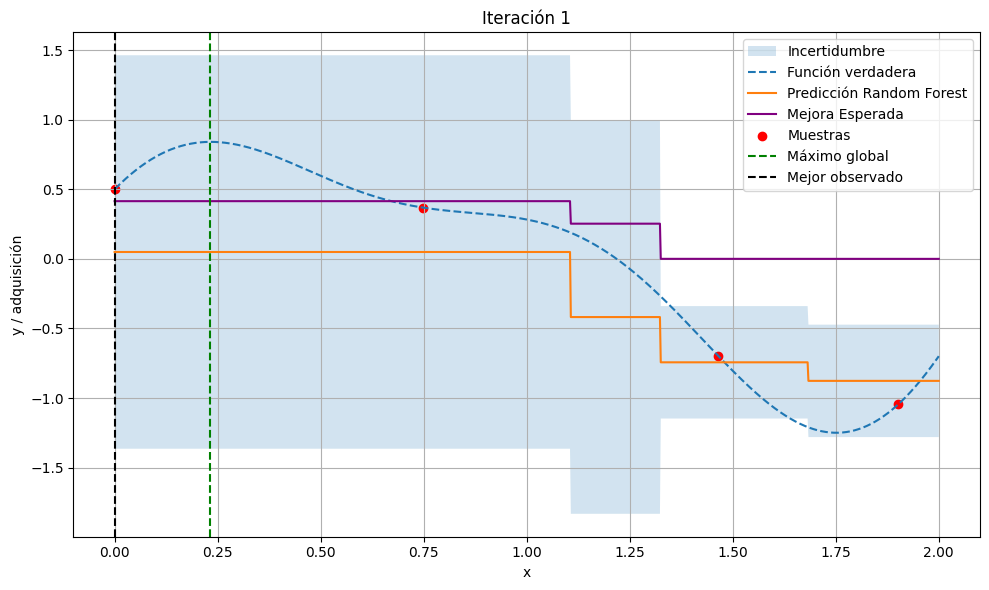

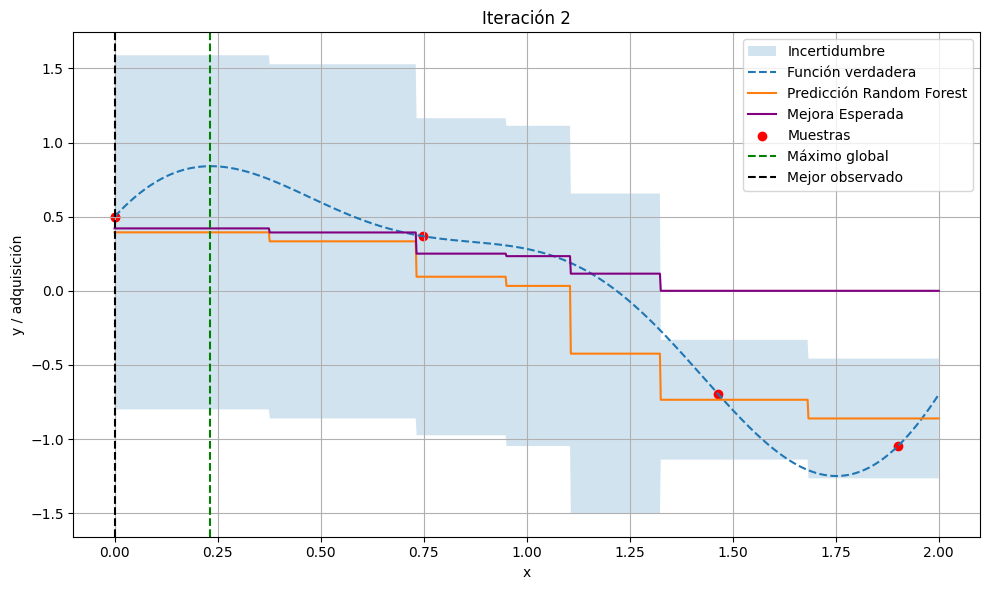

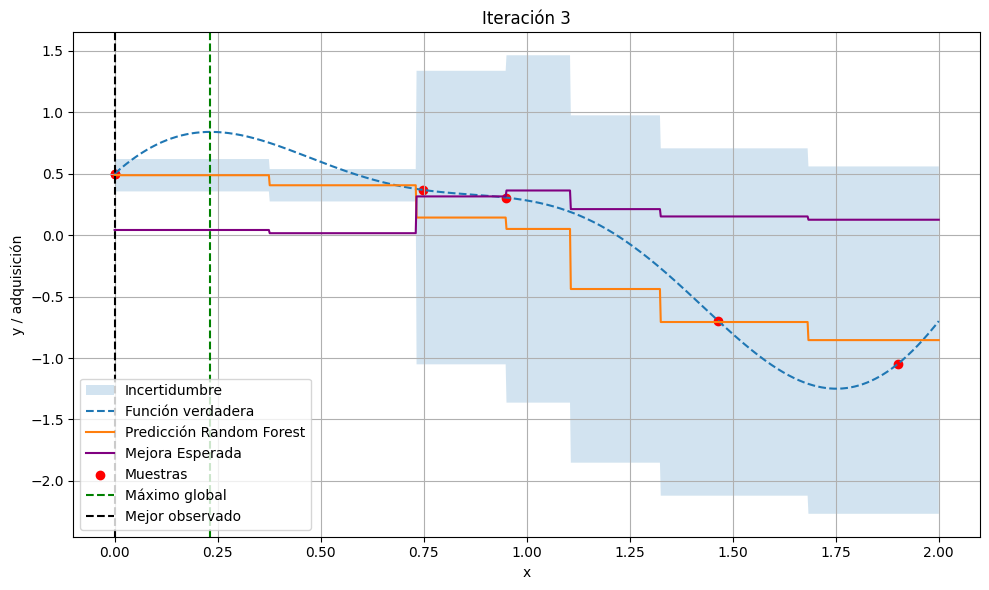

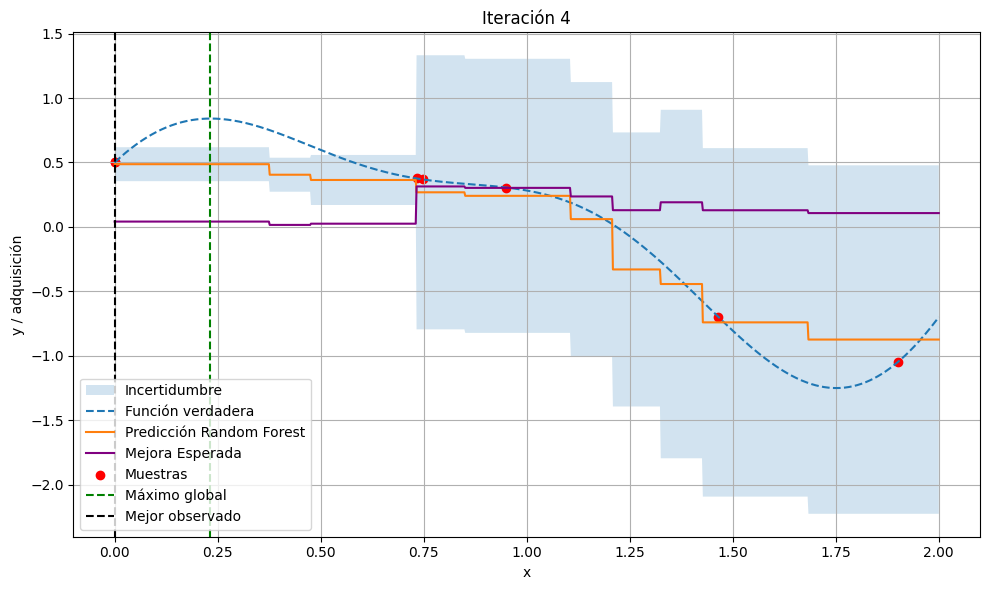

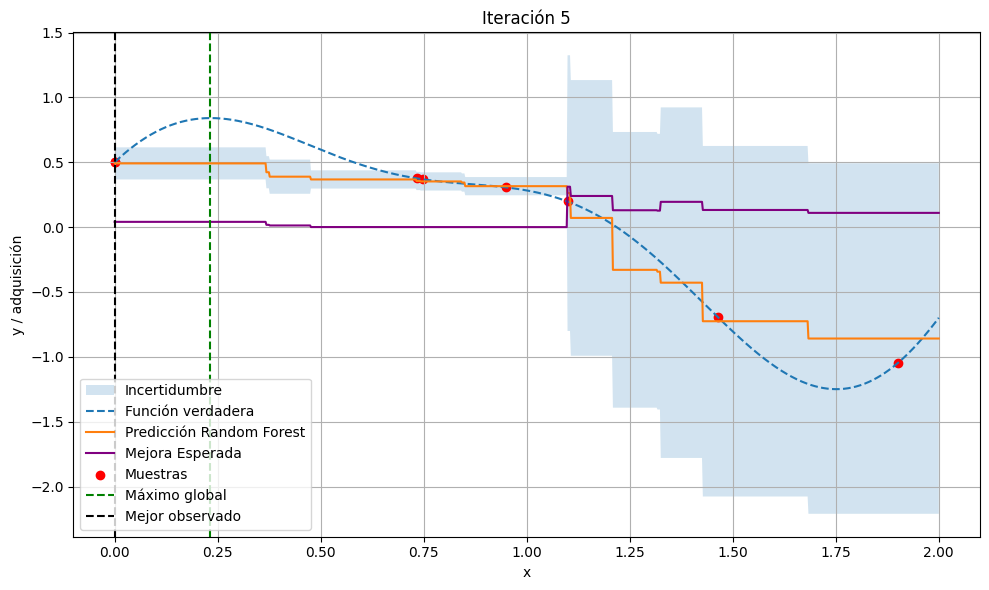

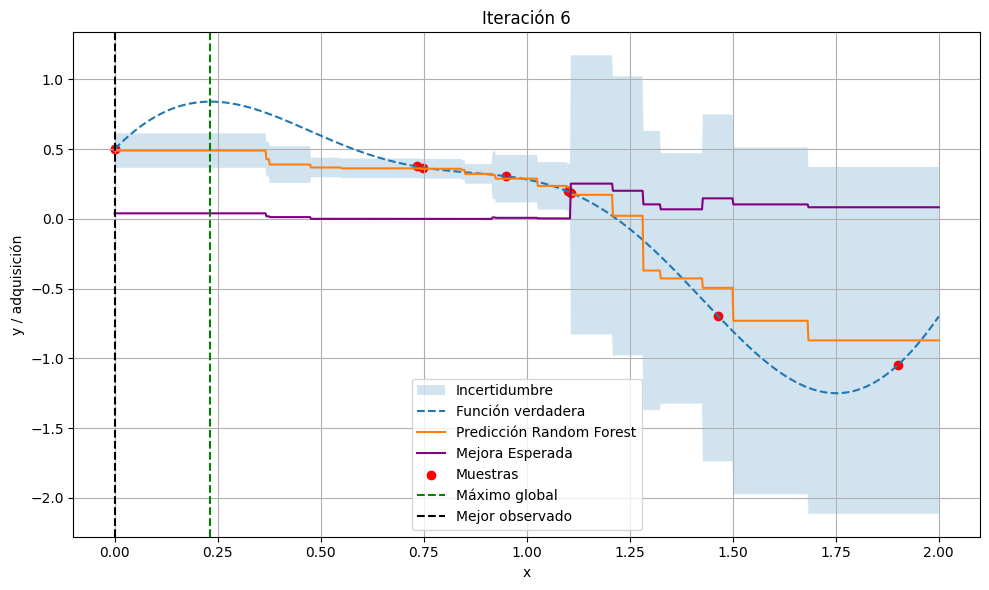

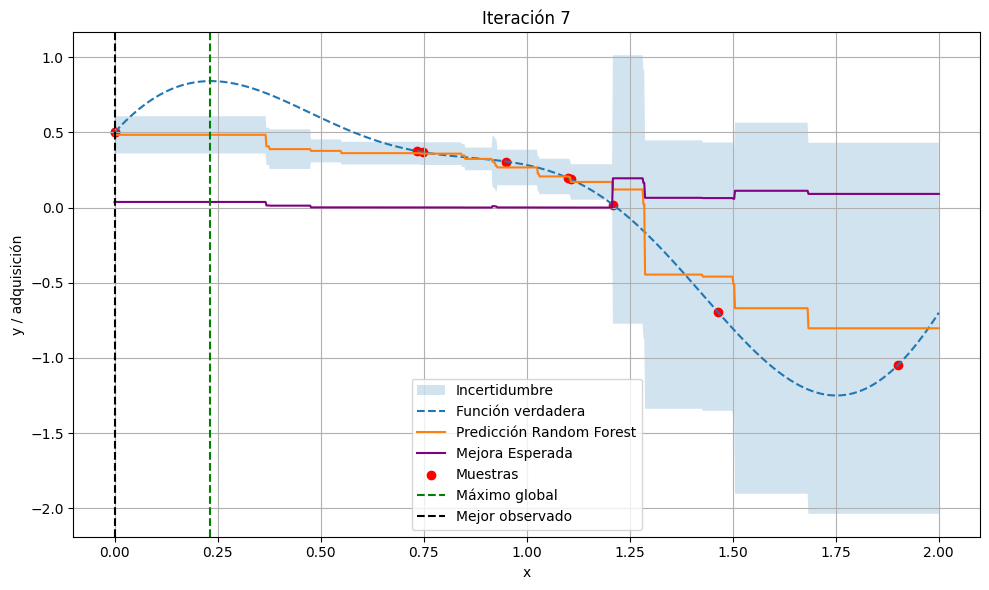

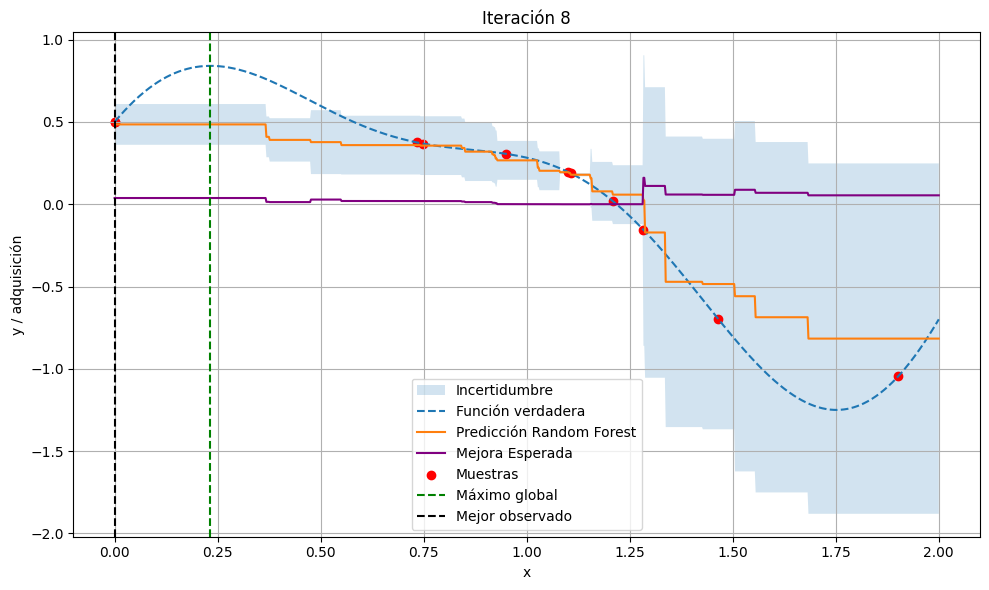

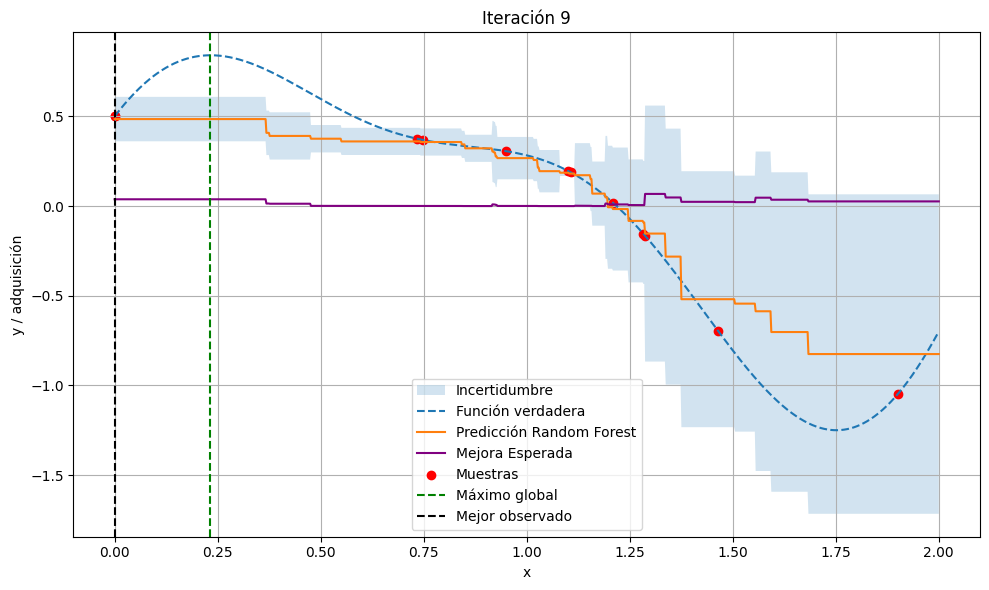

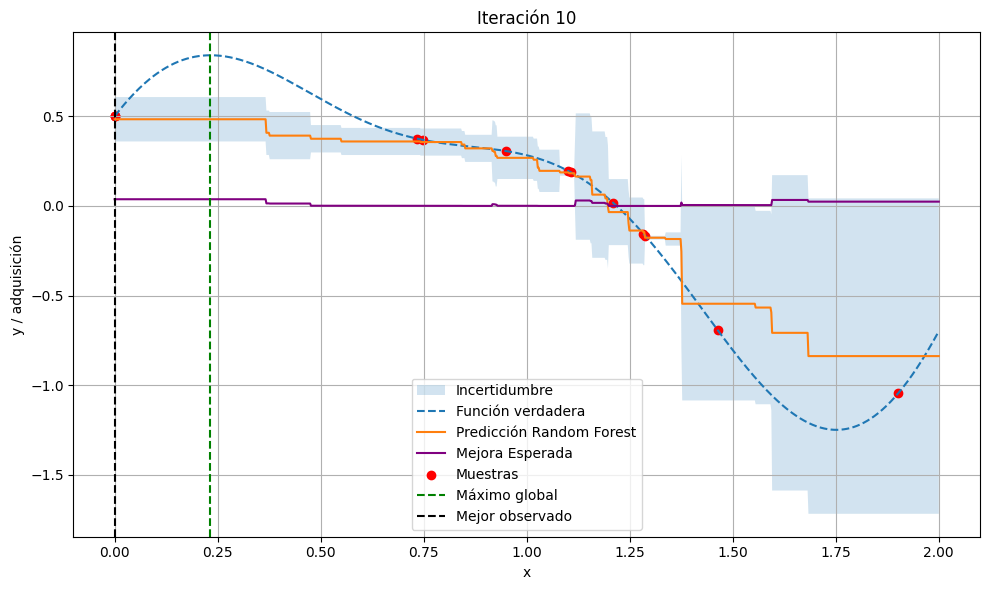

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


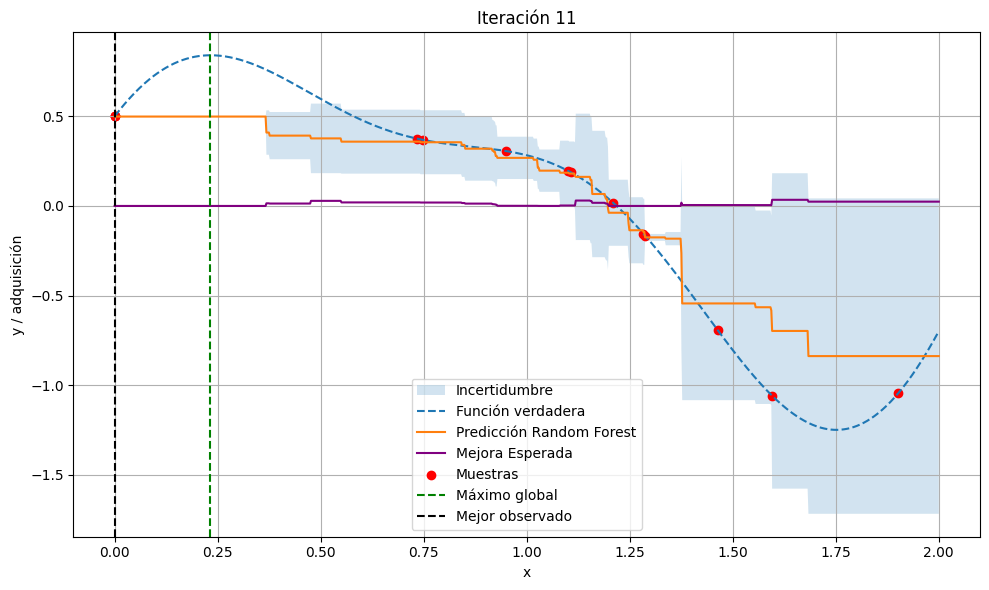

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


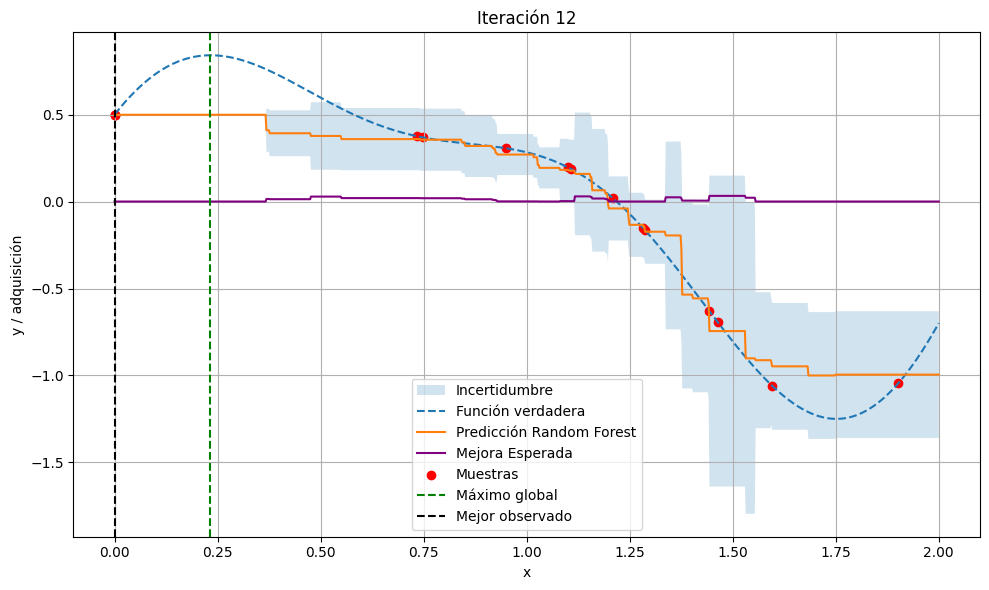

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


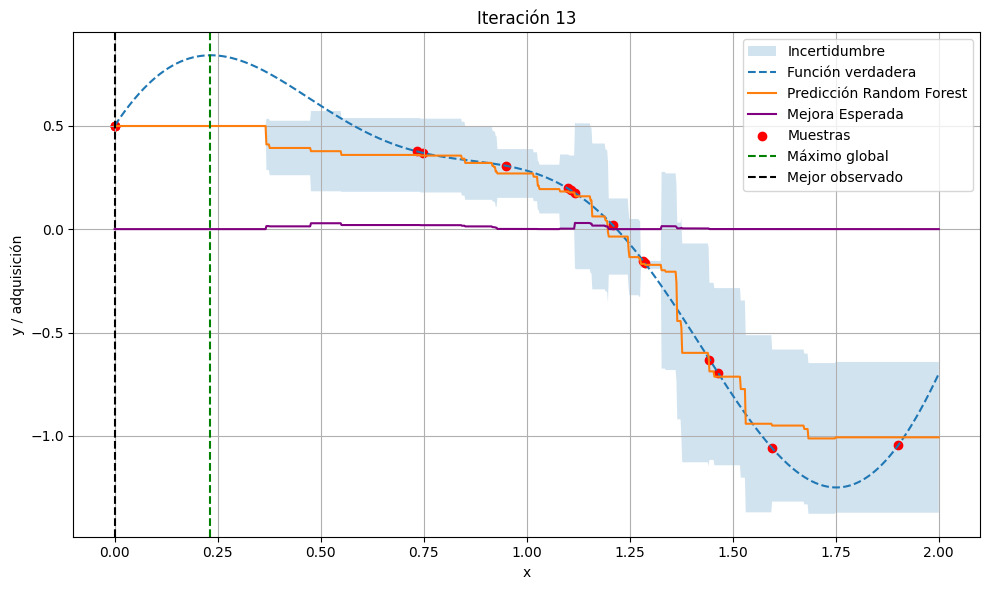

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


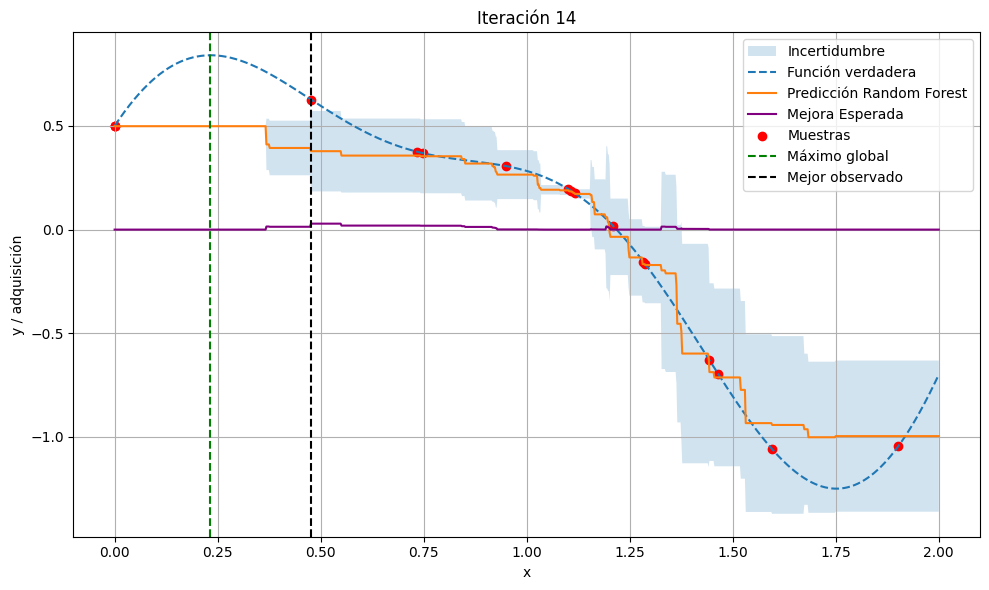

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


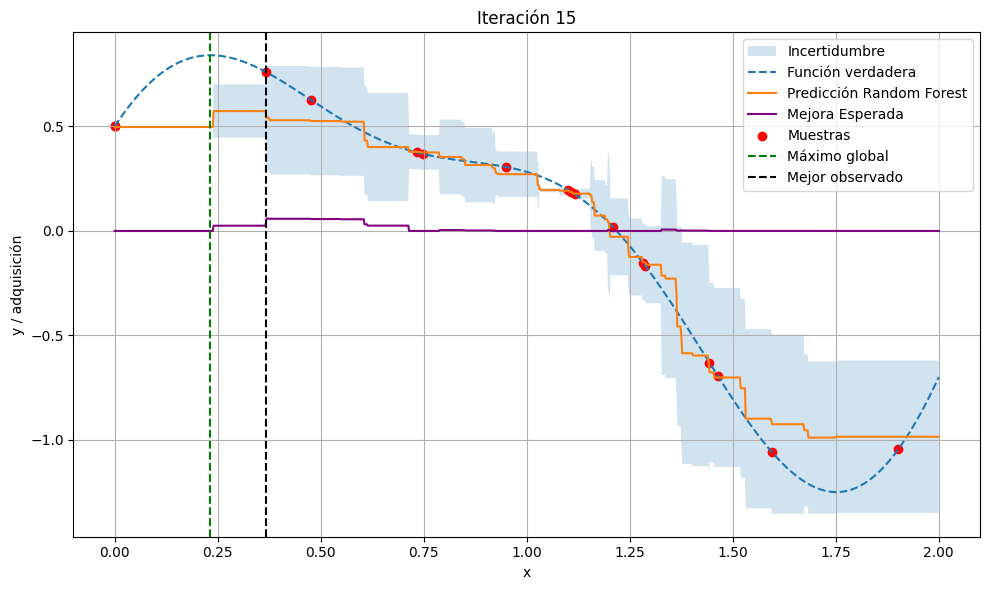

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


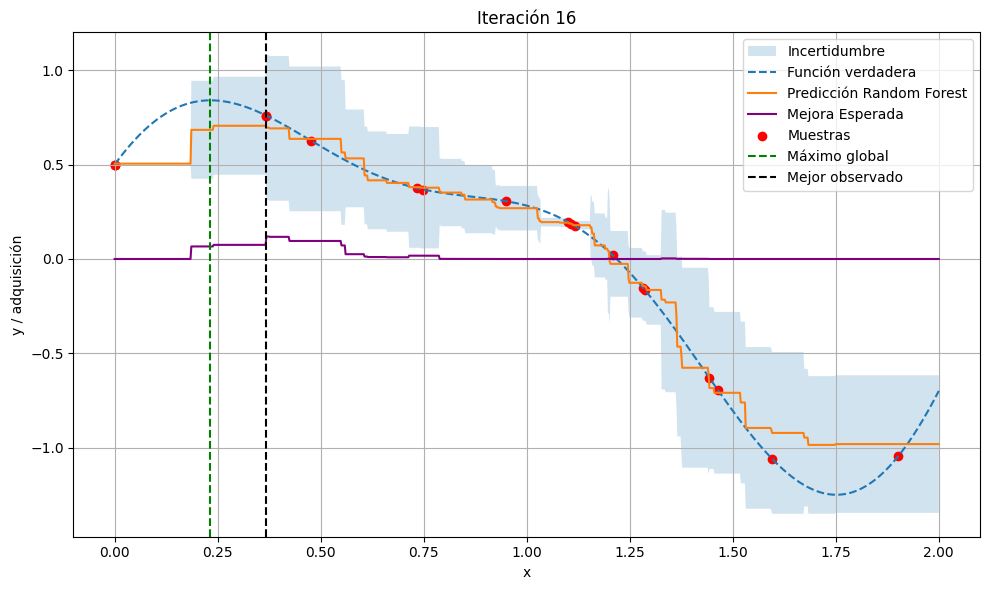

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


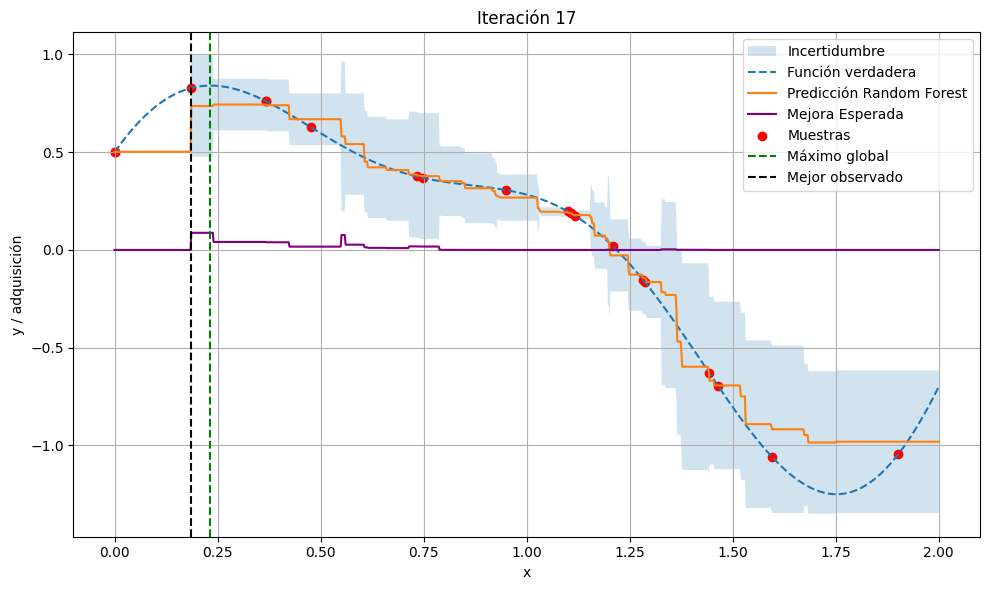

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


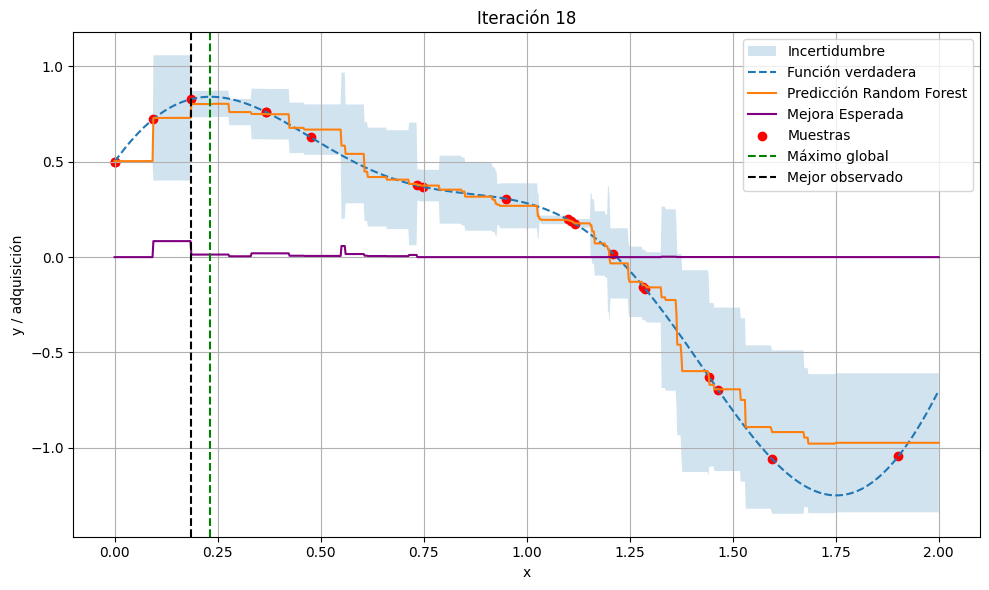

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


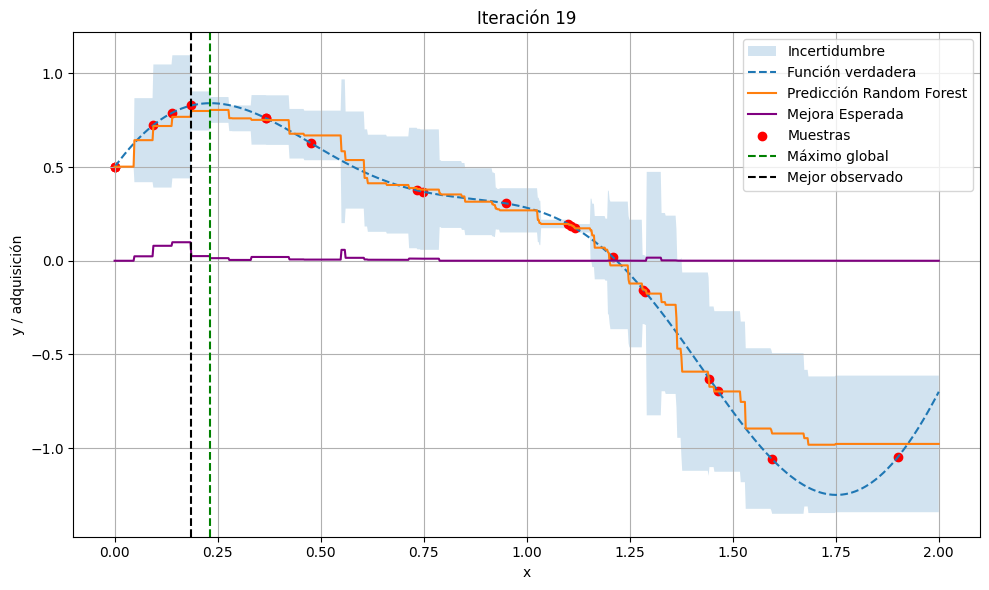

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


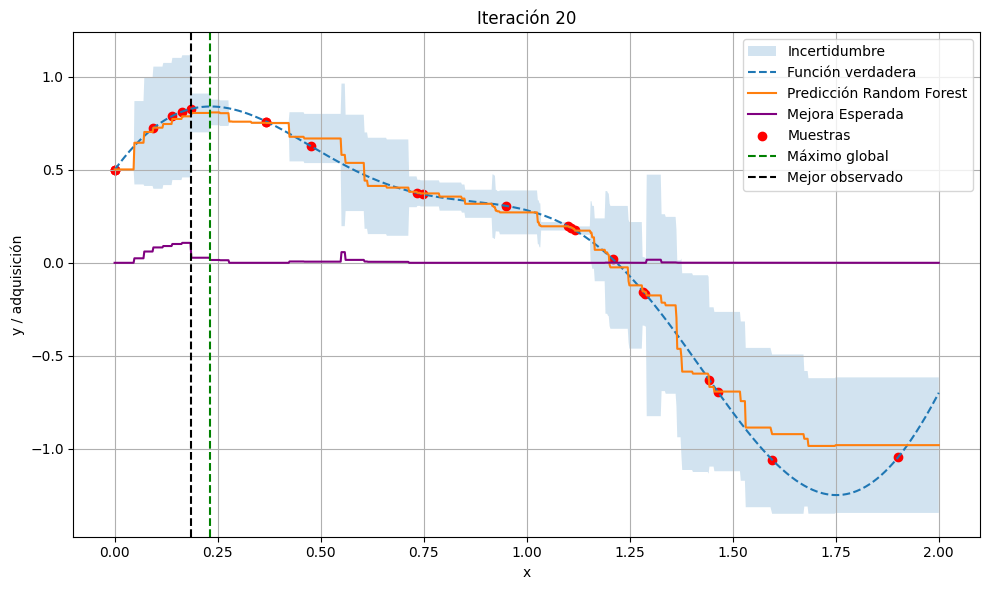

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


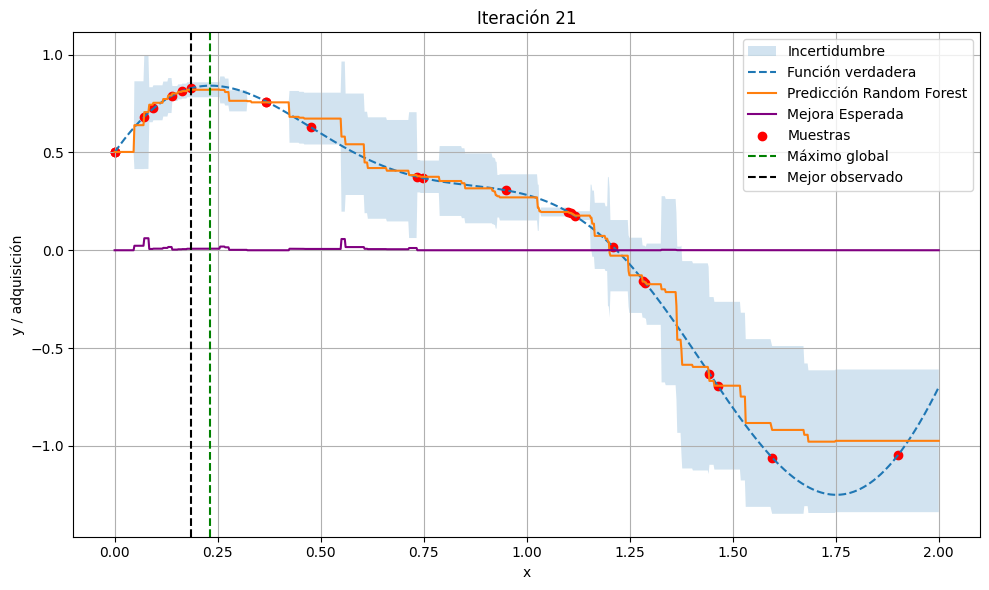

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


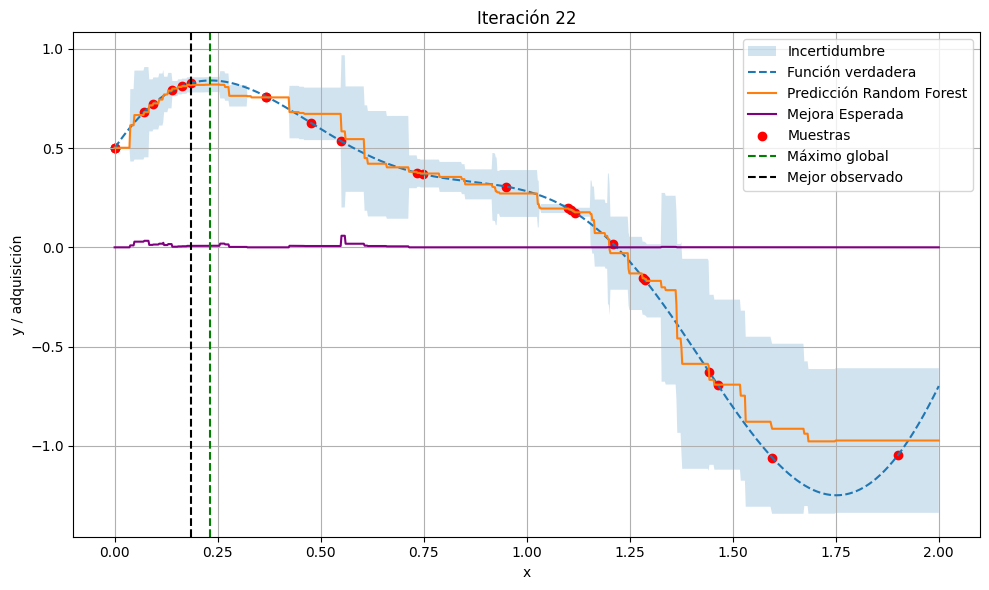

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


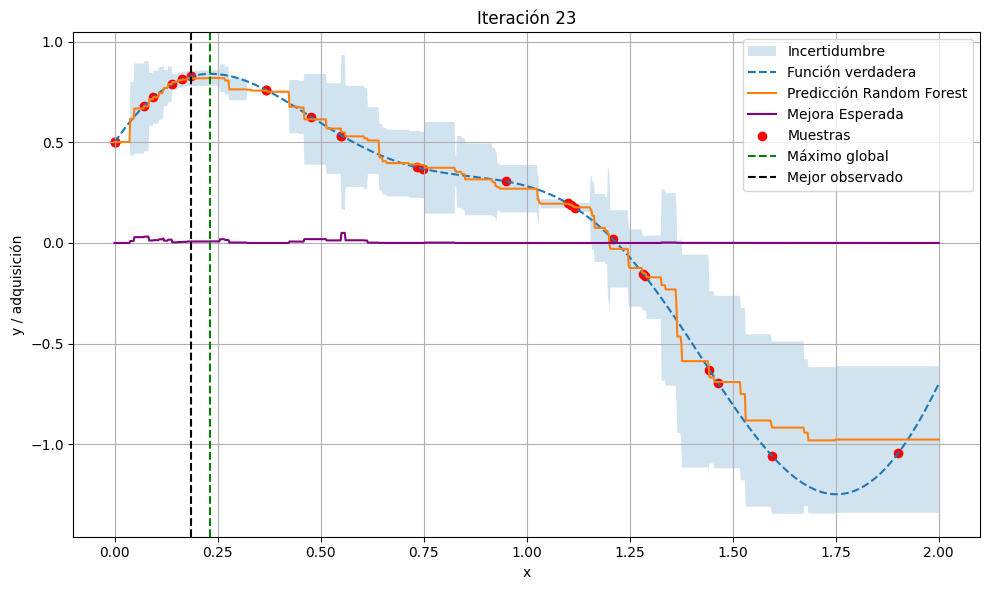

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


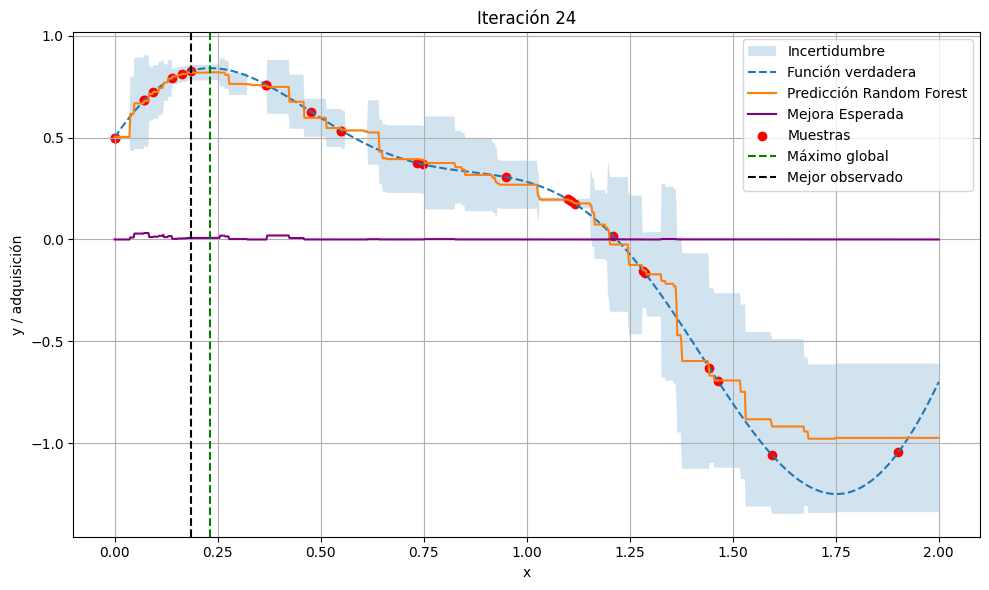

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


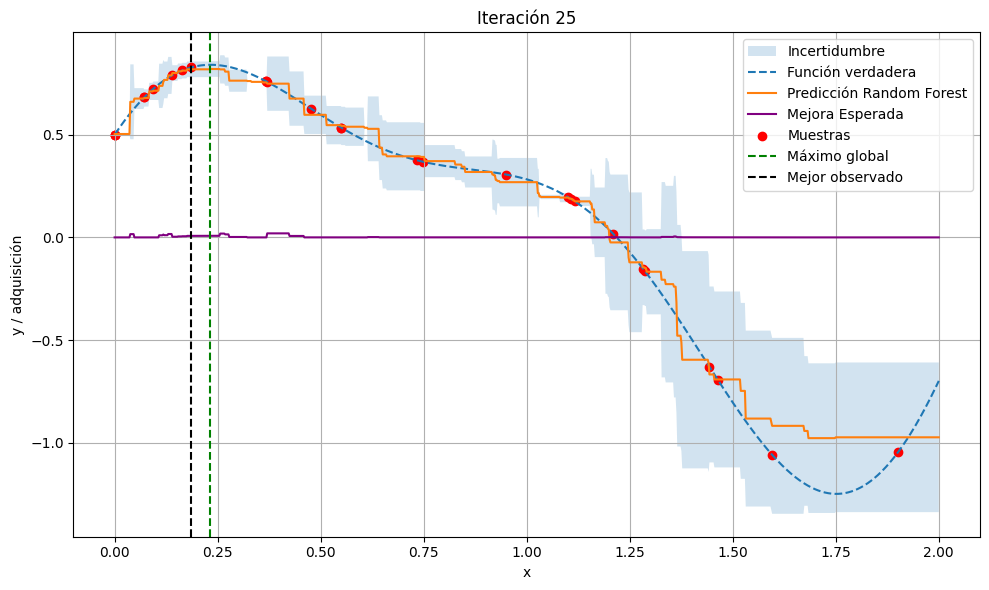

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


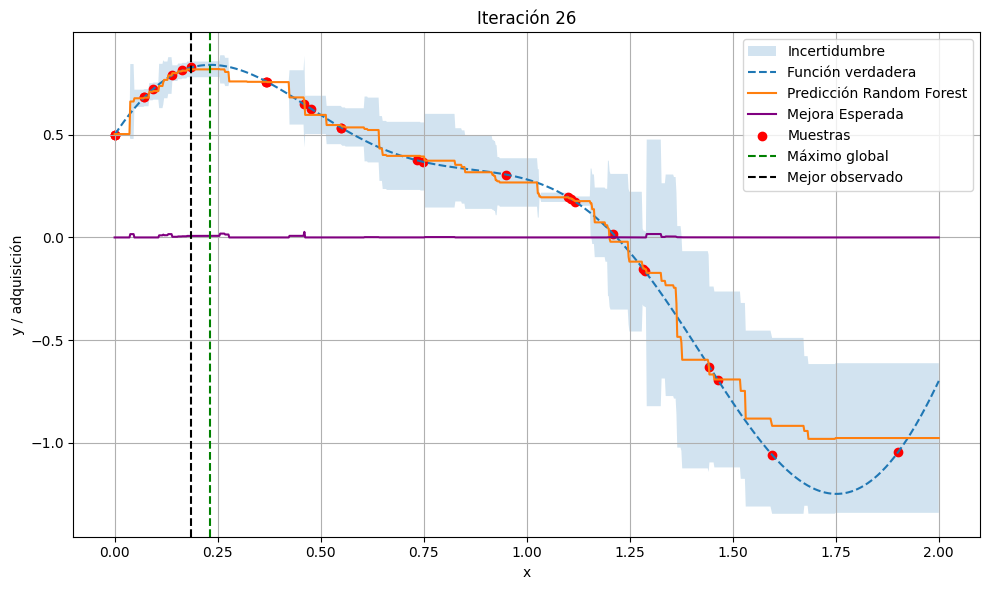

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


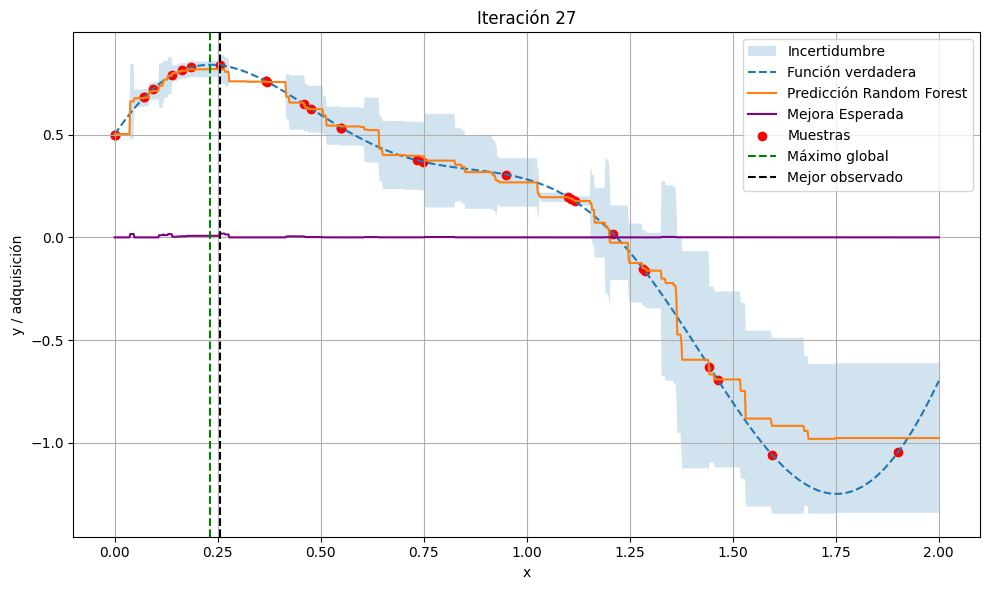

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


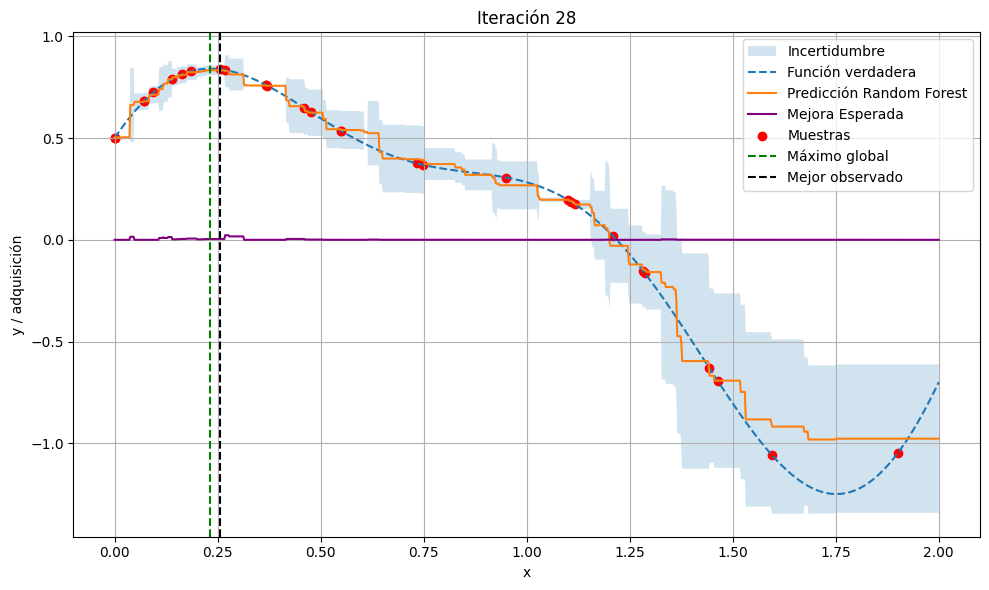

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


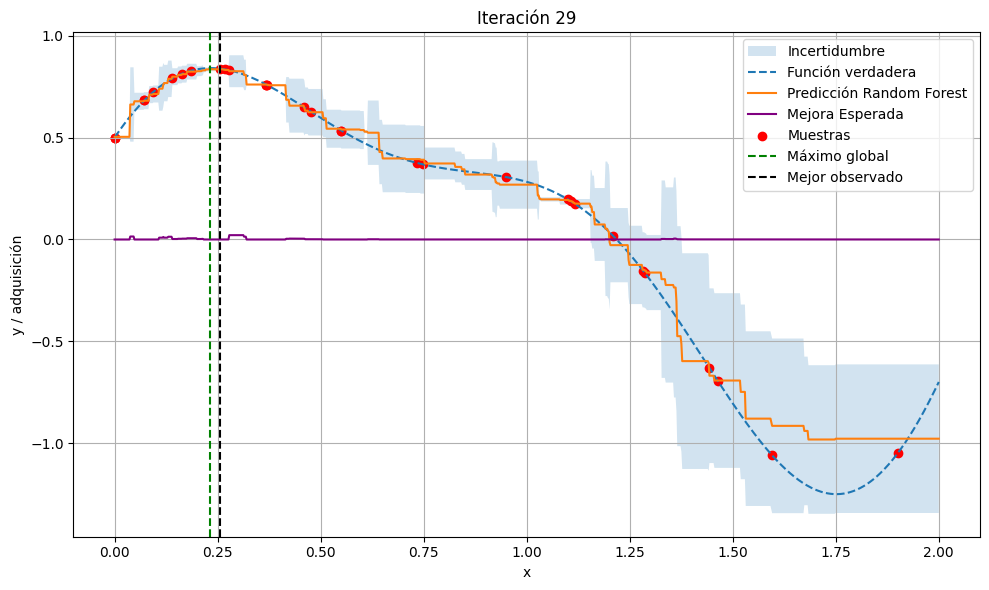

/tmp/ipython-input-26-2526686755.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = mejora / desviacion


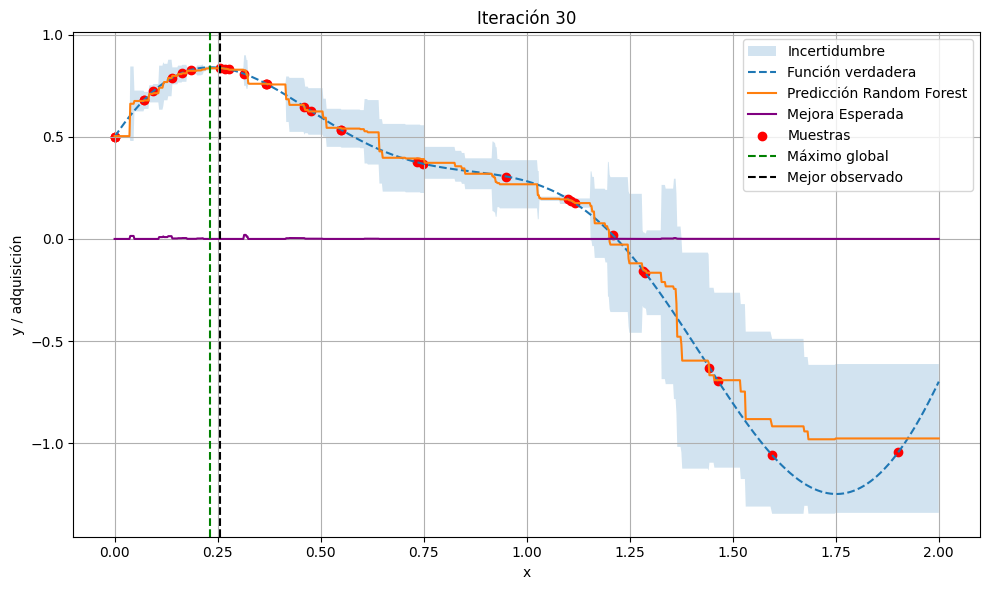

In [ ]:
# ---- Función verdadera (a optimizar) ----
def funcion_objetivo(x):
    return np.sin(3 * x) + 0.5 * np.cos(5 * x)

# ---- Inicialización ----
np.random.seed(42)
limites = np.array([[0, 2]])
X_denso = np.linspace(limites[0, 0], limites[0, 1], 1000).reshape(-1, 1)
y_verdadero = funcion_objetivo(X_denso)

# Muestras iniciales
X_entrenamiento = np.random.uniform(limites[0, 0], limites[0, 1], size=(3, 1))
y_entrenamiento = funcion_objetivo(X_entrenamiento)

# Creamos el modelo de Random Forest con 100 arboles
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# -------------------------------------------------------------------------------------------- Bucle de Aprendizaje Activo con  EXPECTED IMPROVEMENT---------------------------------------------------------------------------
n_iteraciones = 30
for iteracion in range(n_iteraciones):
    # Ajustar el modelo
    rf_fitted=rf.fit(X_entrenamiento, y_entrenamiento)

    # Predecir
    media_pred, desviacion_pred = rfPredictionUncertainty(rf_fitted,X_denso)
    ei = mejora_esperada(X_denso, rf_fitted, np.max(y_entrenamiento))

    # Seleccionar el siguiente punto
    x_siguiente = X_denso[np.argmax(ei)]
    y_siguiente = funcion_objetivo(x_siguiente)

    # Agregar nueva muestra
    X_entrenamiento = np.vstack((X_entrenamiento, x_siguiente))
    y_entrenamiento = np.append(y_entrenamiento, y_siguiente)

    # ---- Graficar ----
    plt.figure(figsize=(10, 6))
    plt.fill_between(X_denso.ravel(), media_pred - desviacion_pred, media_pred + desviacion_pred, alpha=0.2, label='Incertidumbre')
    plt.plot(X_denso, y_verdadero, '--', label='Función verdadera')
    plt.plot(X_denso, media_pred, label='Predicción Random Forest')
    plt.plot(X_denso, ei, label='Mejora Esperada', color='purple')
    plt.scatter(X_entrenamiento, y_entrenamiento, color='red', label='Muestras')
    plt.axvline(X_denso[np.argmax(y_verdadero)], color='green', linestyle='--', label='Máximo global')
    plt.axvline(X_entrenamiento[np.argmax(y_entrenamiento)], color='black', linestyle='--', label='Mejor observado')
    plt.title(f"Iteración {iteracion + 1}")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y / adquisición")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


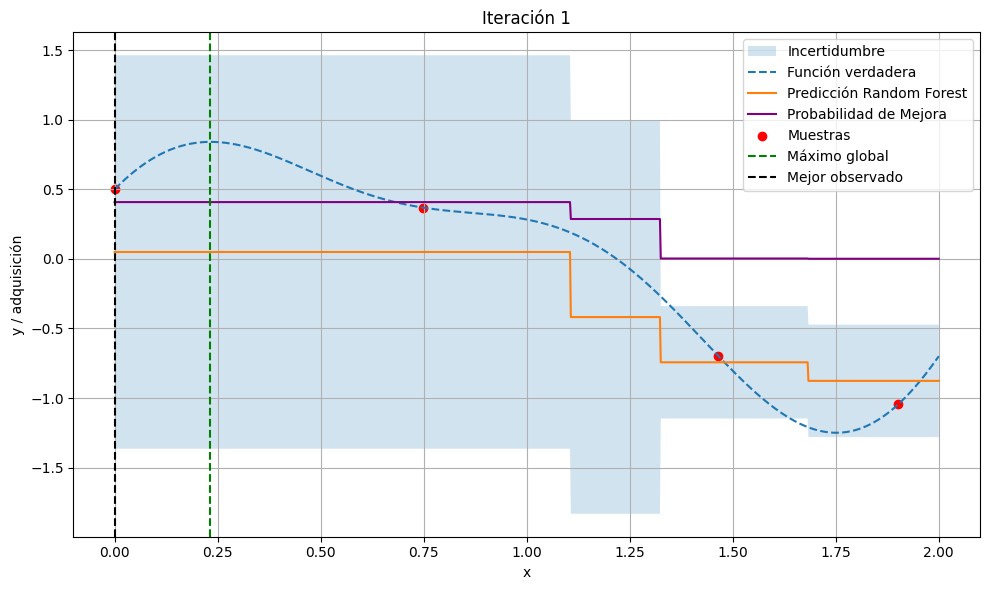

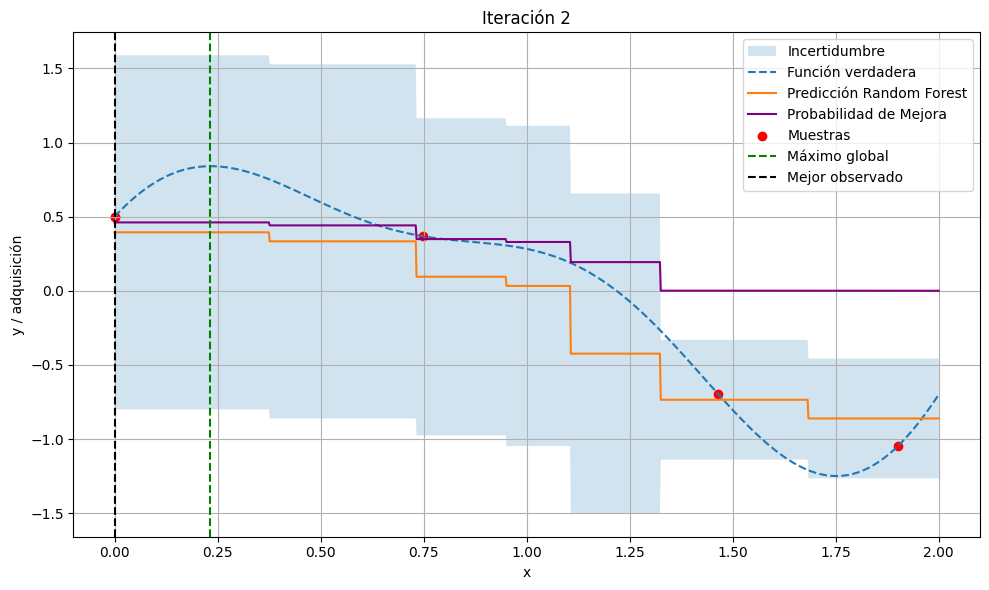

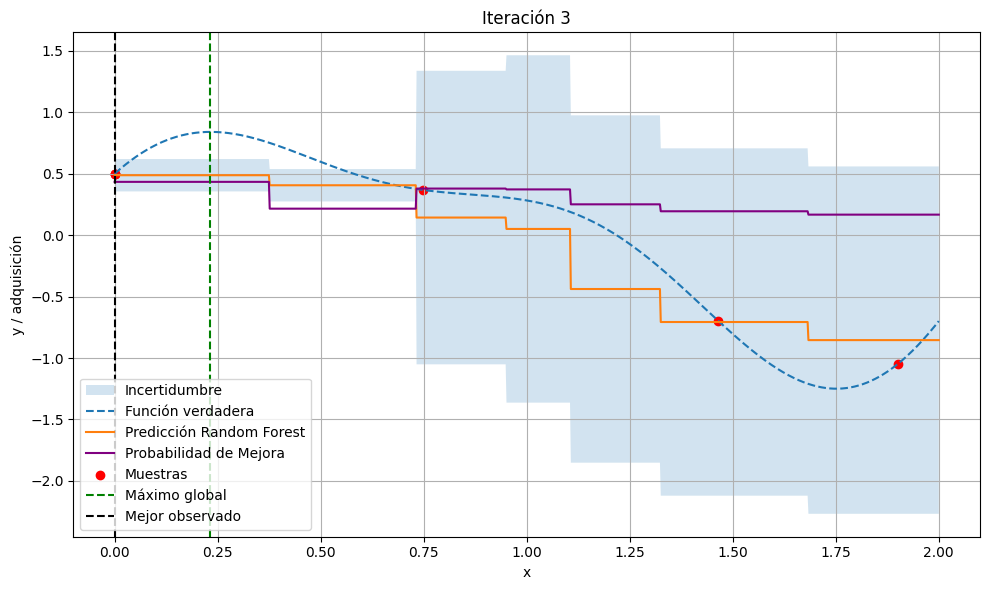

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


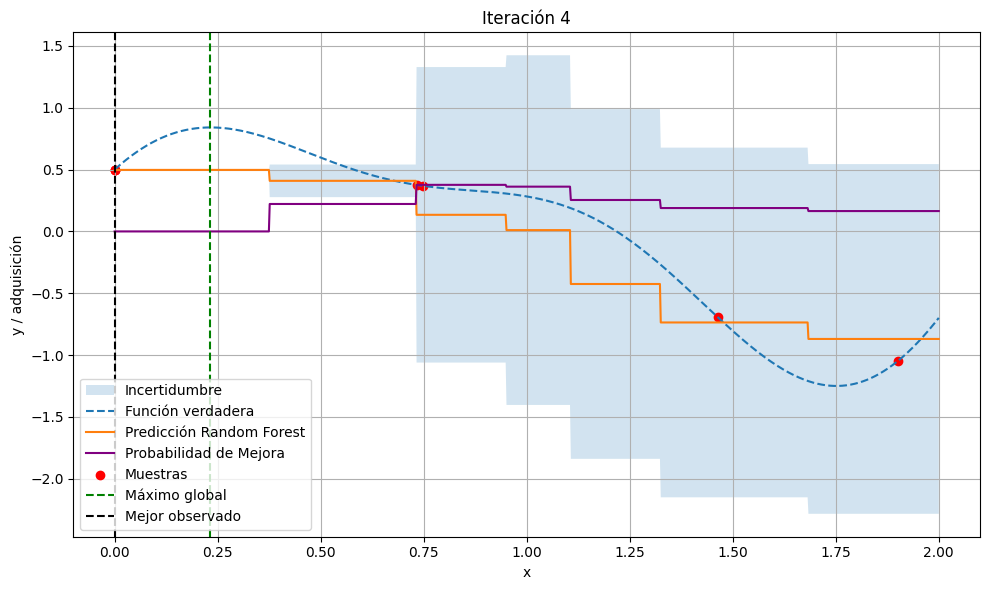

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


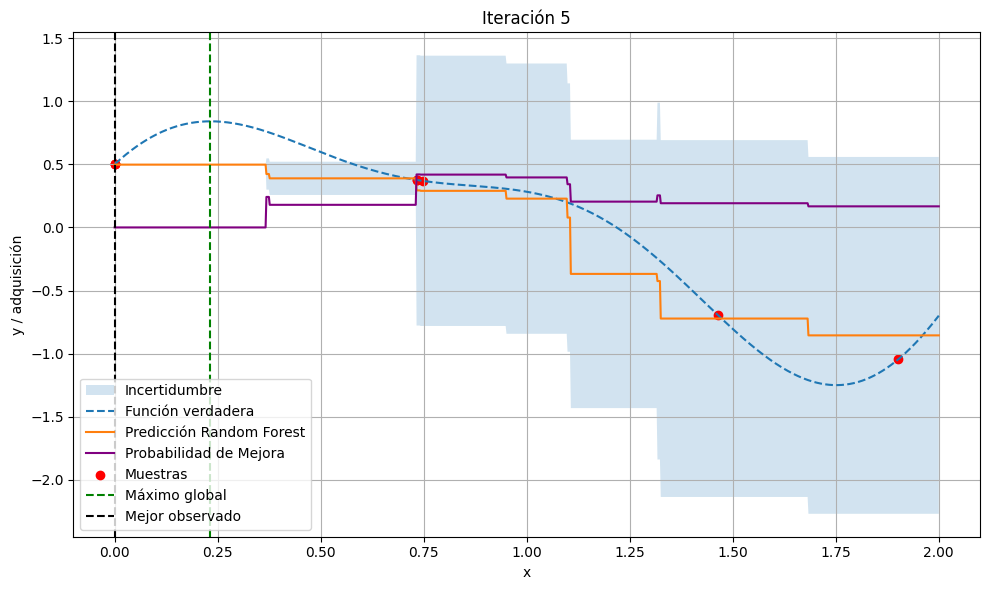

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


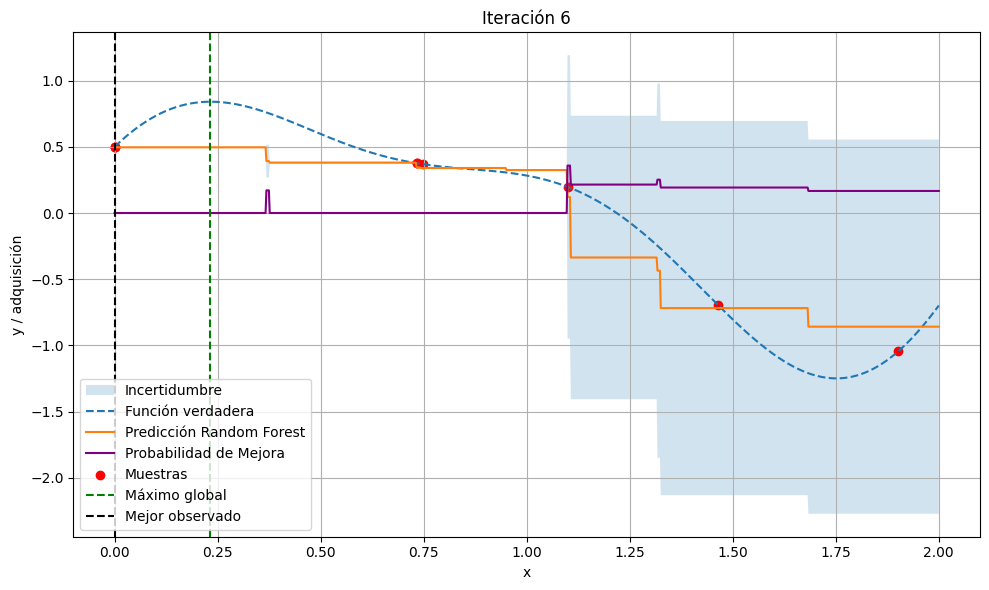

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


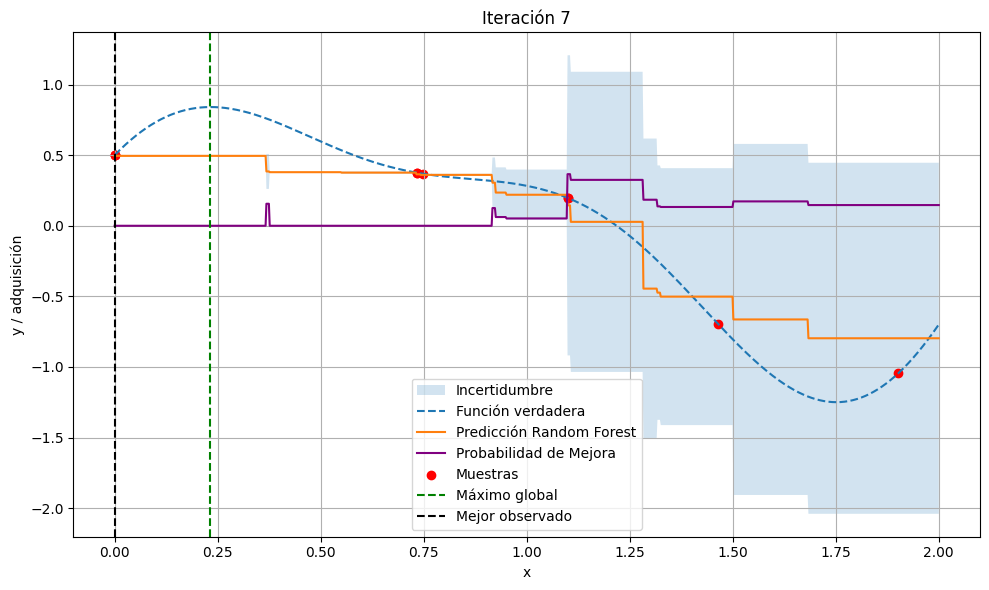

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


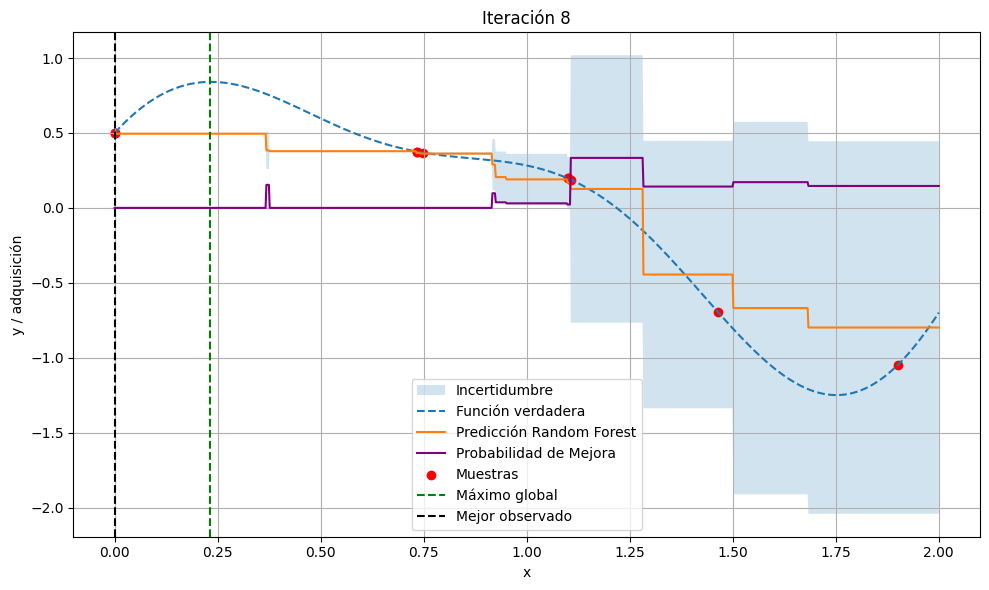

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


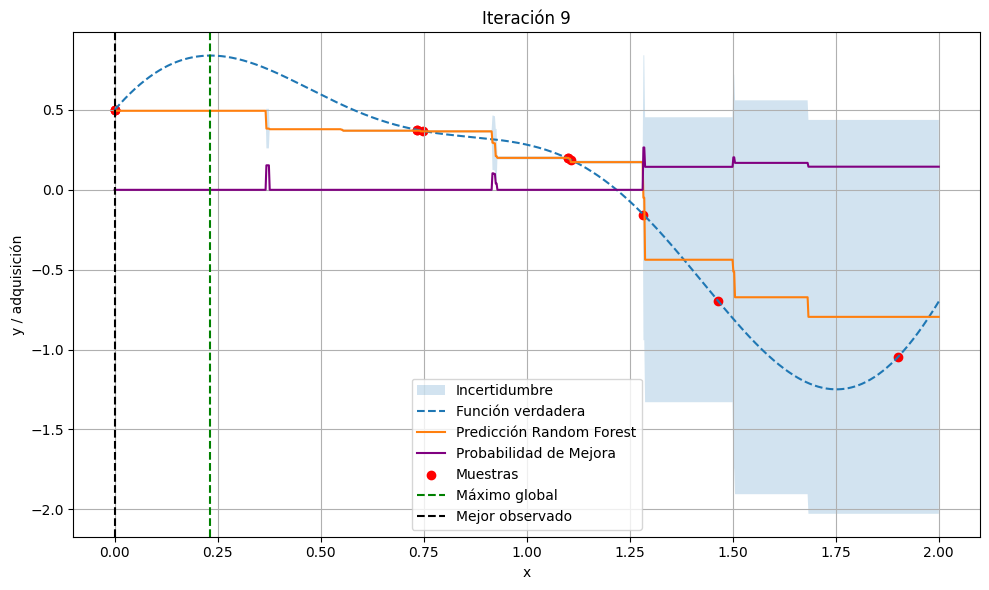

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


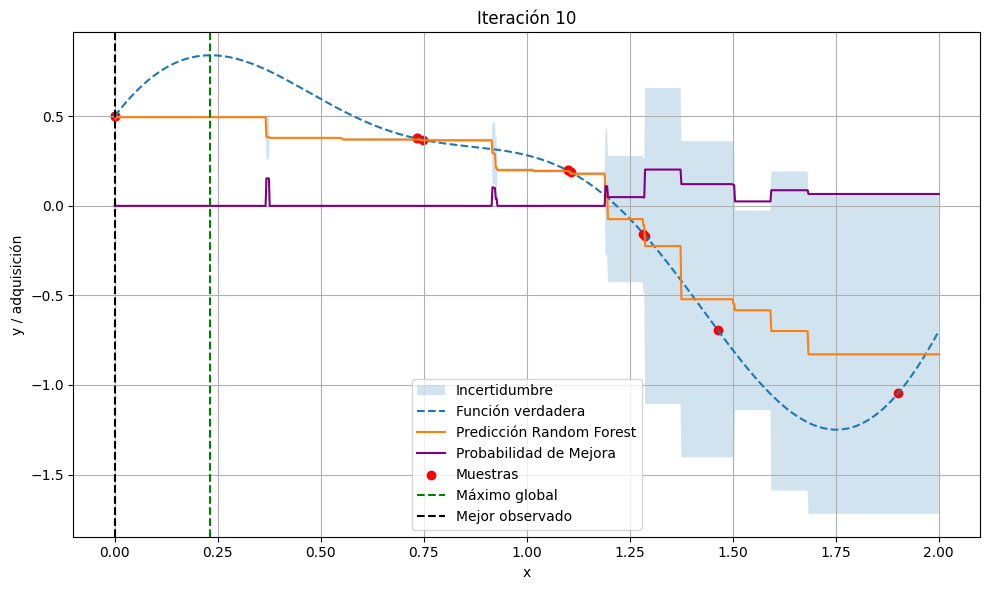

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


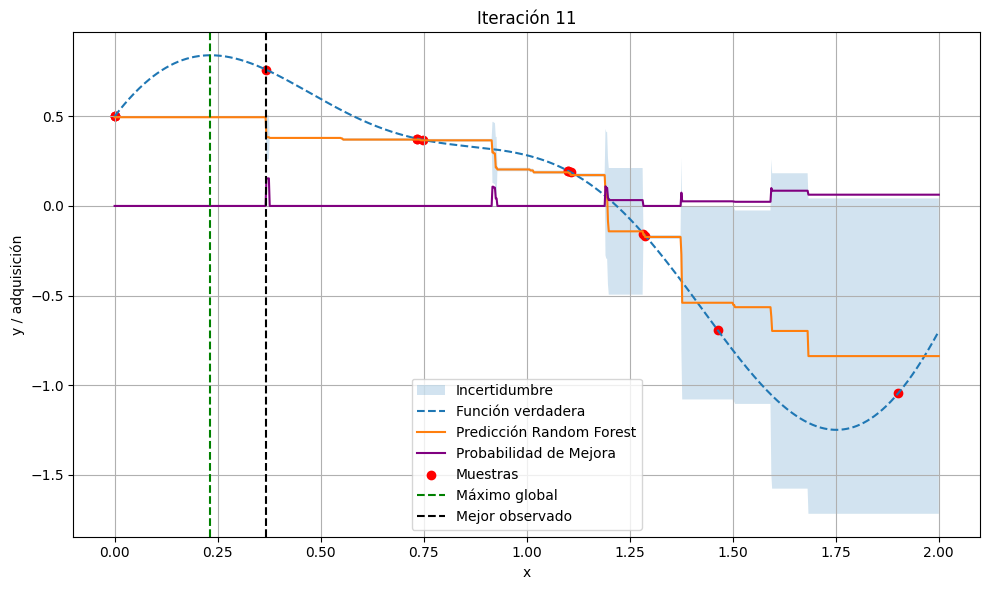

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


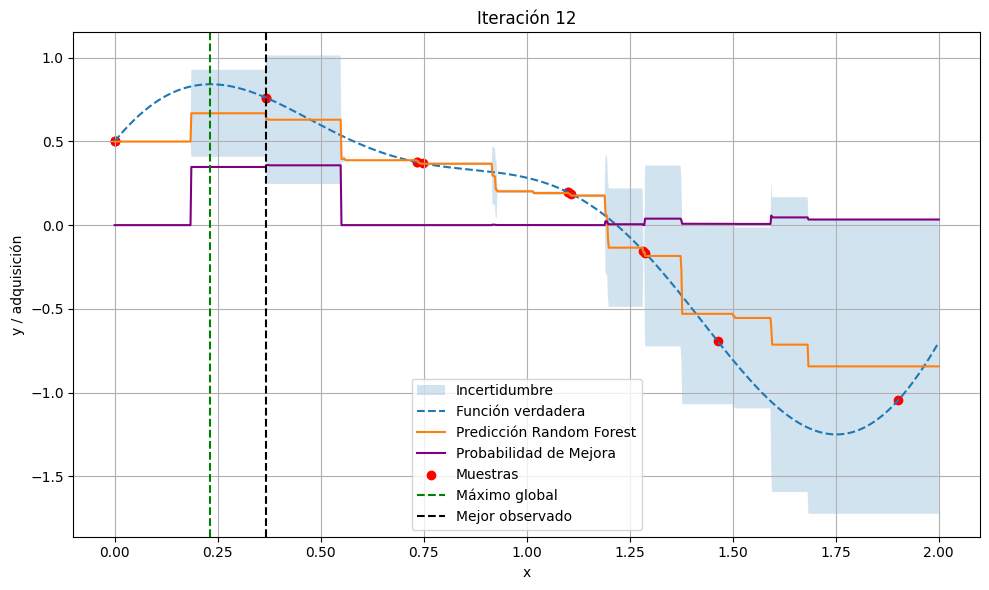

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


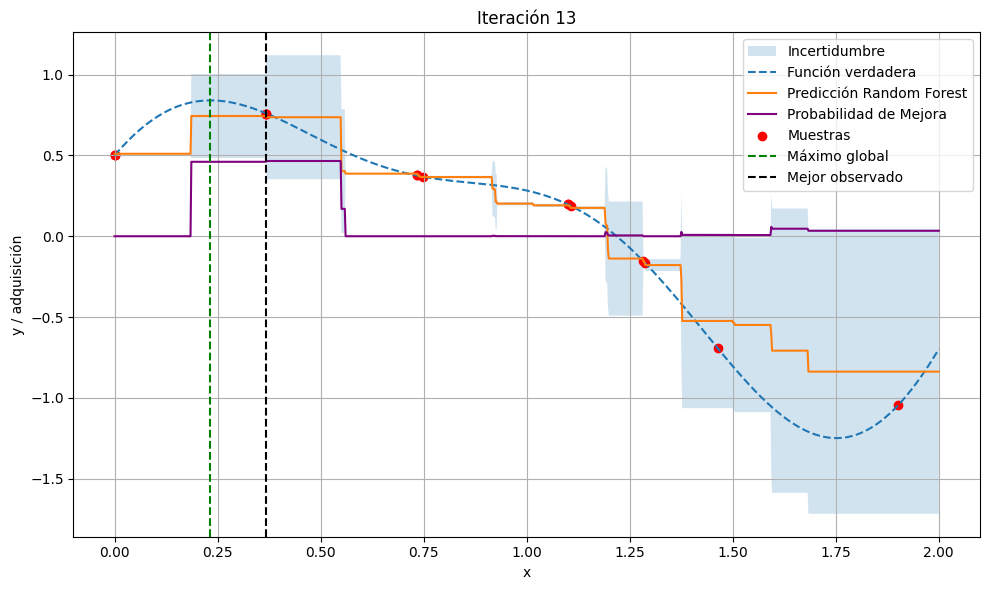

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


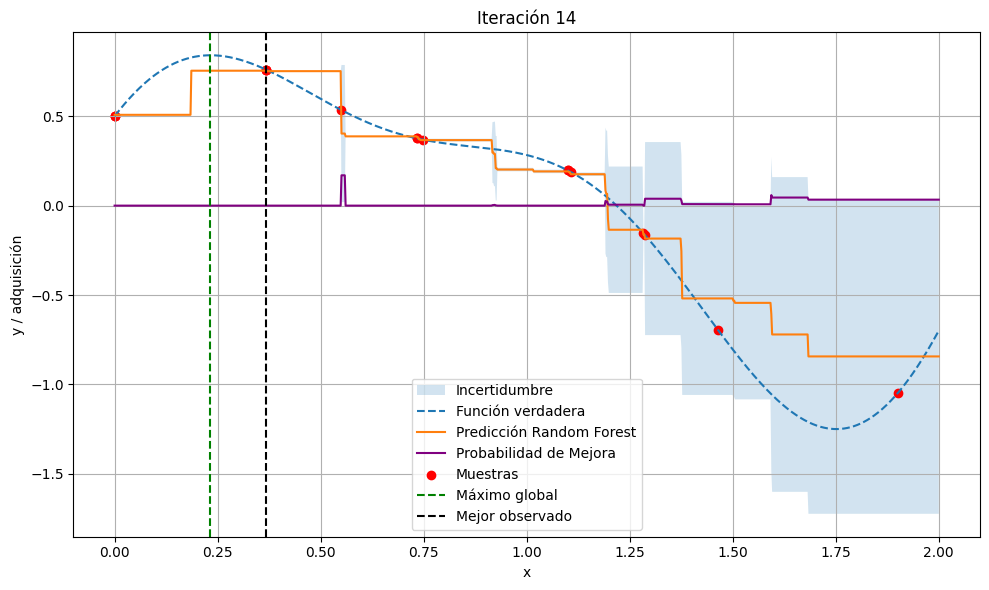

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


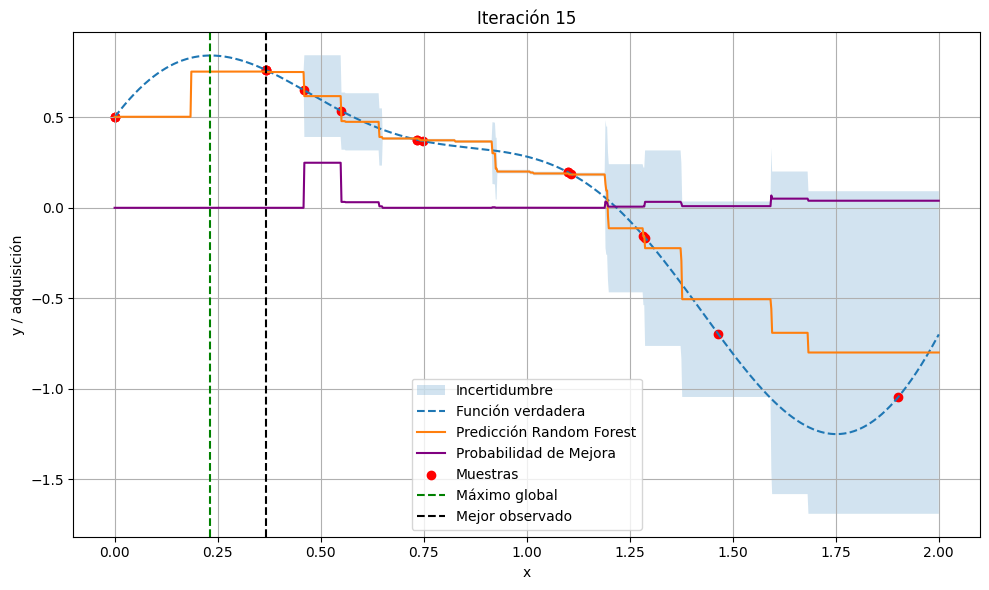

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


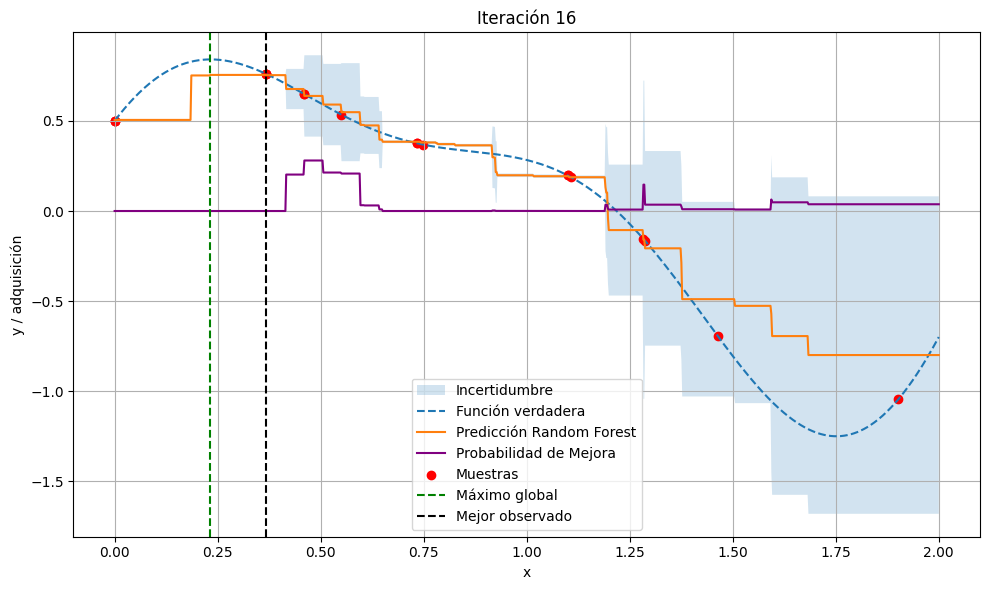

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


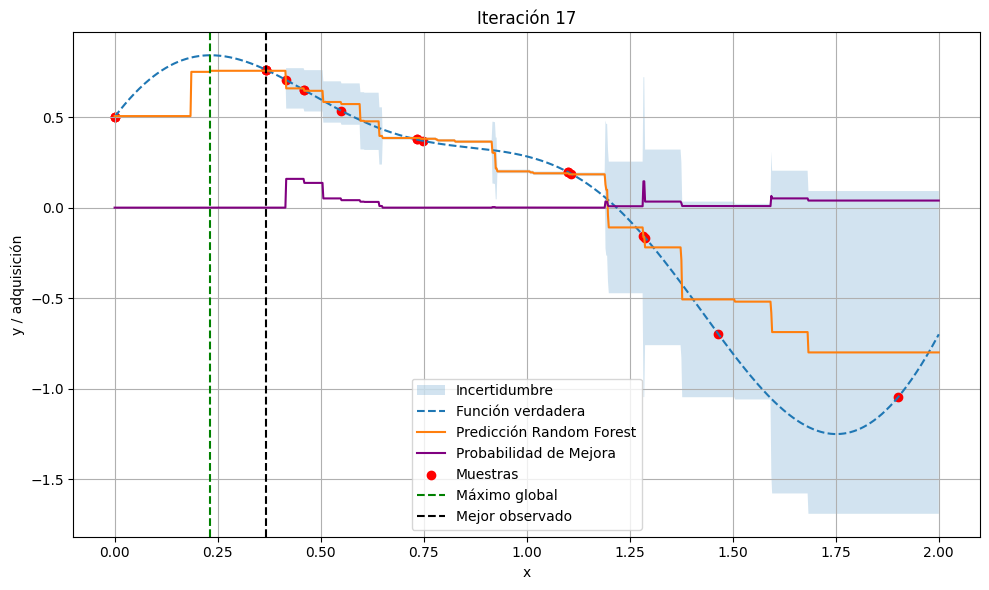

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


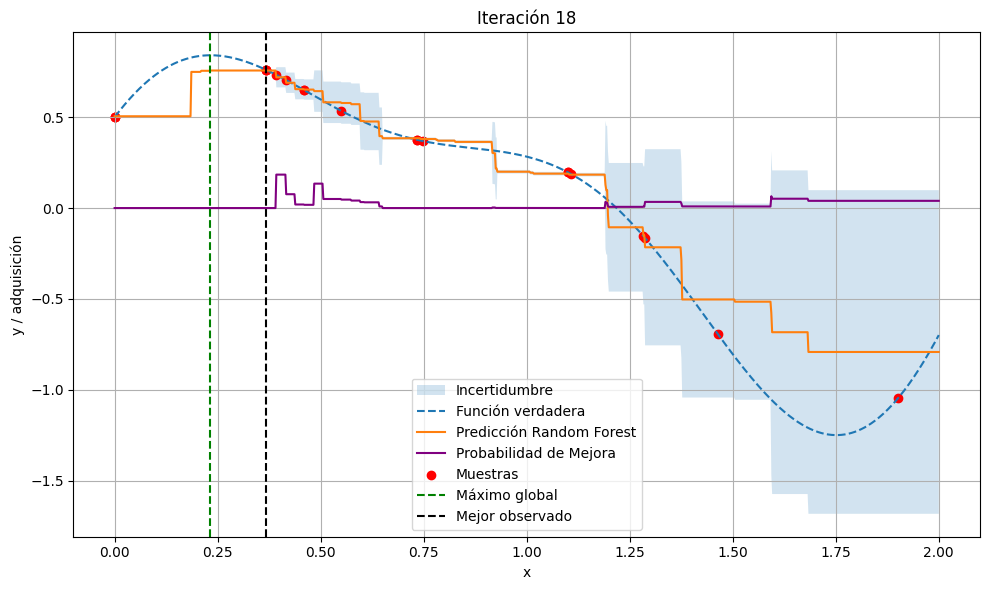

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


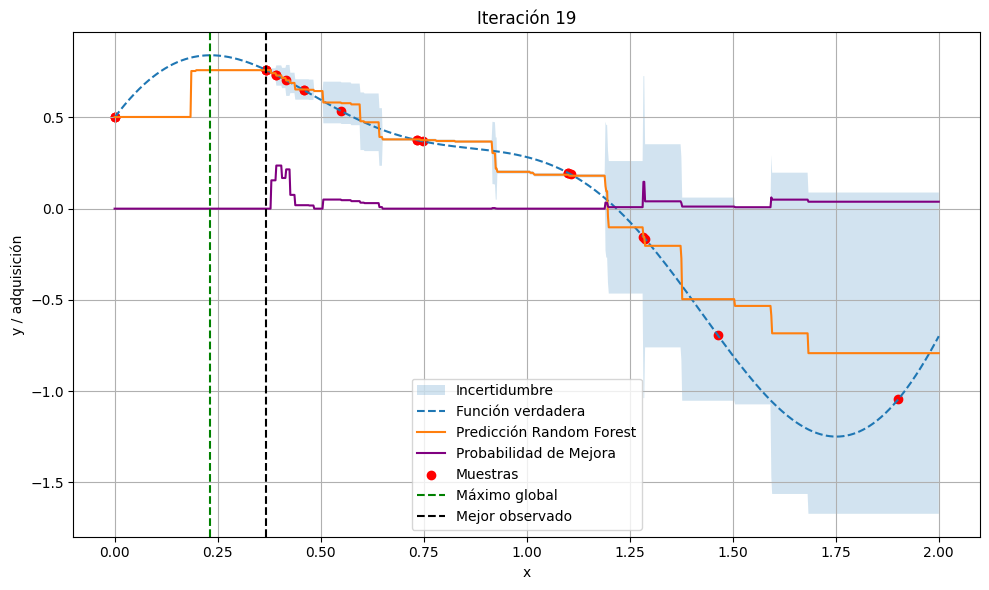

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


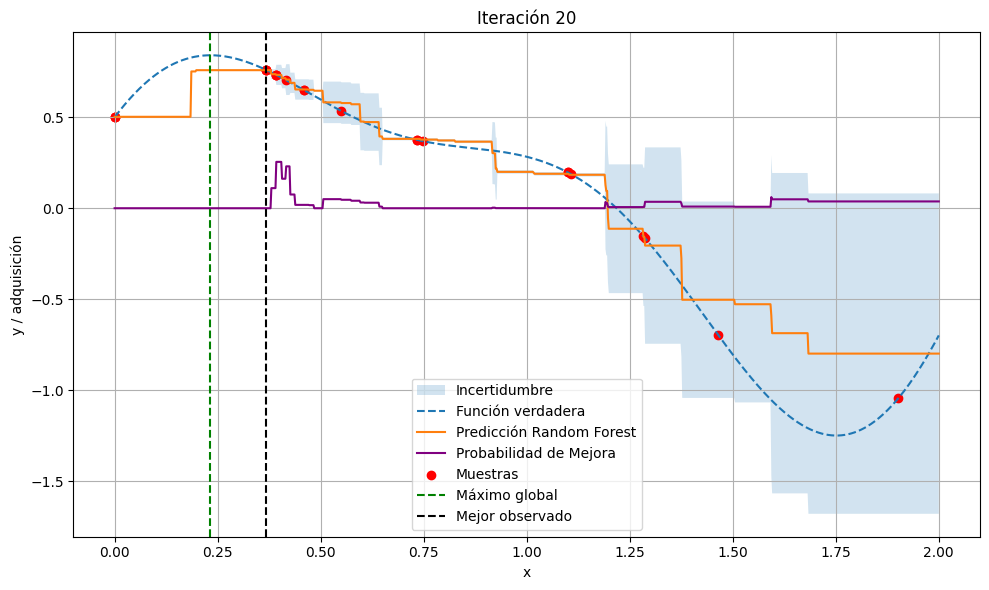

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


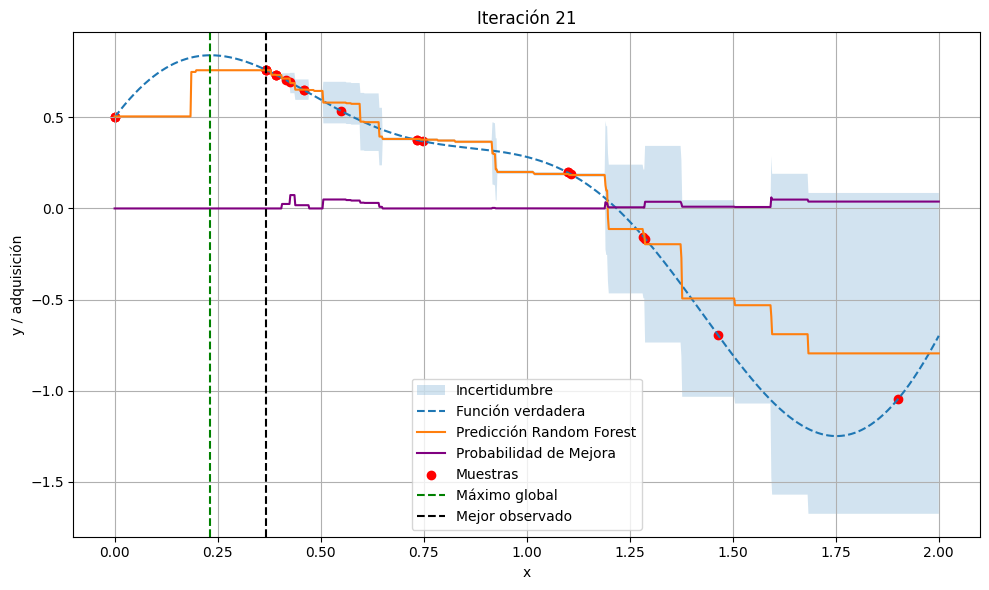

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


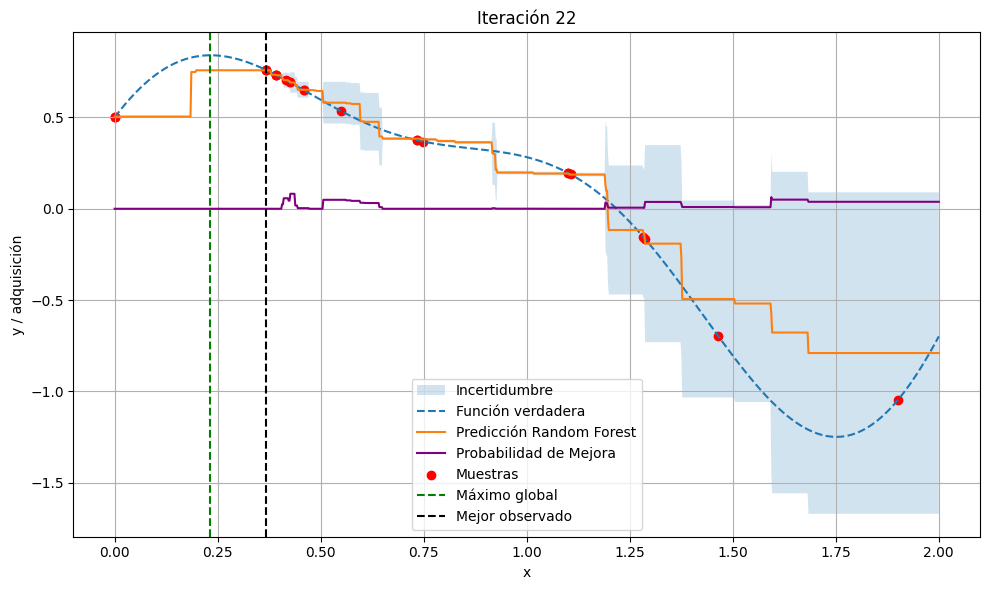

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


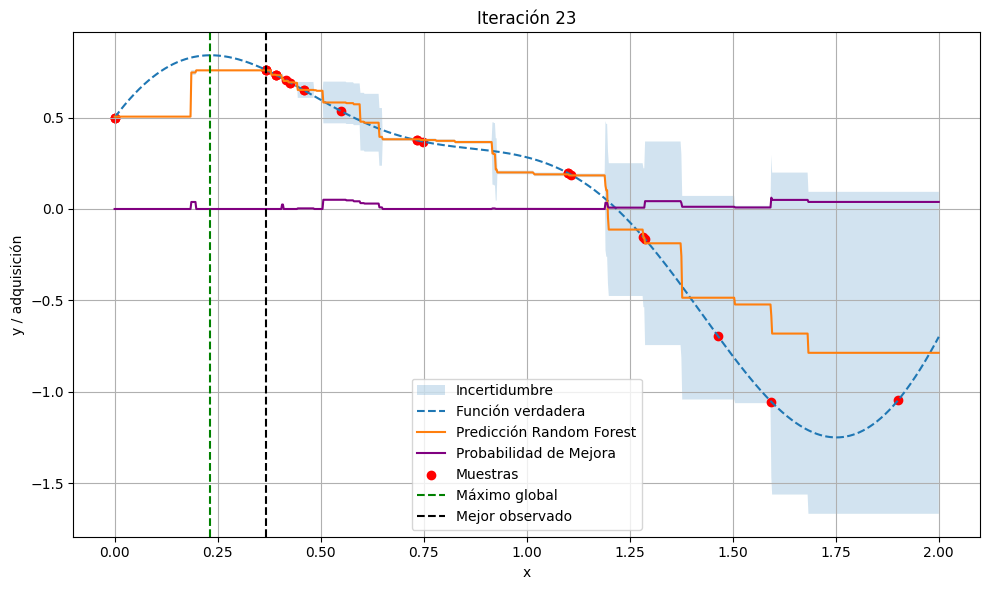

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


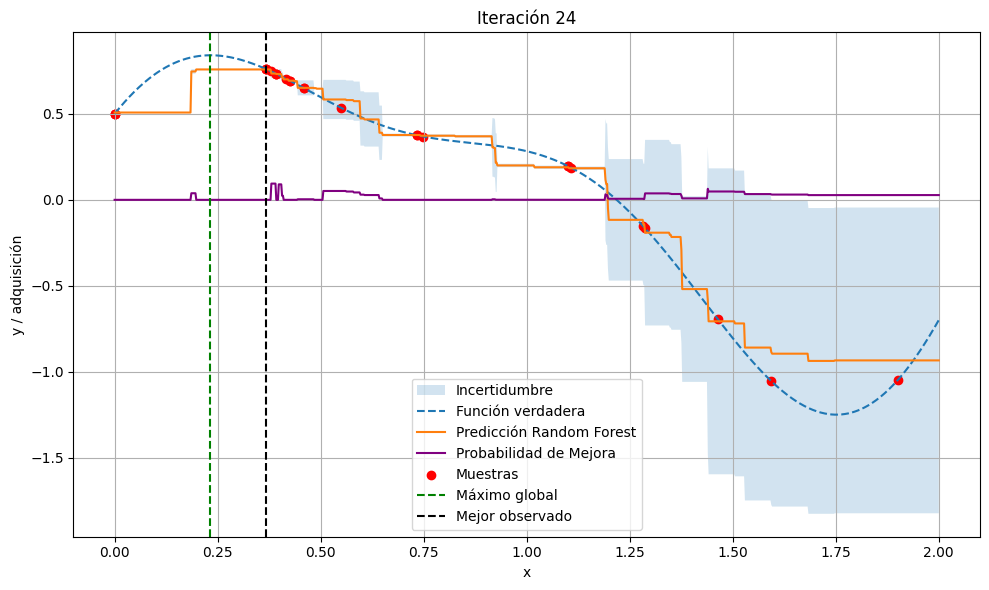

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


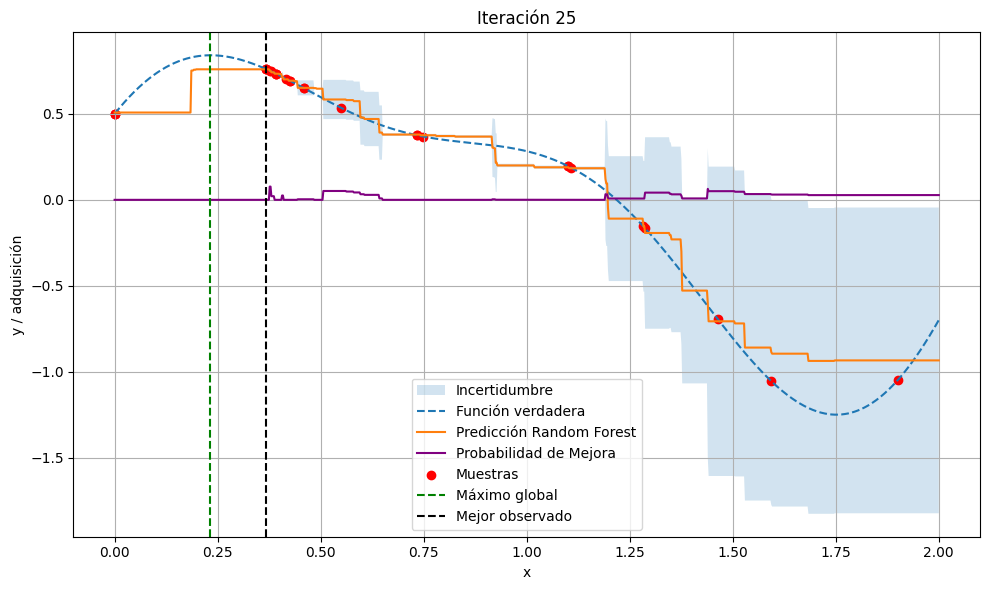

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


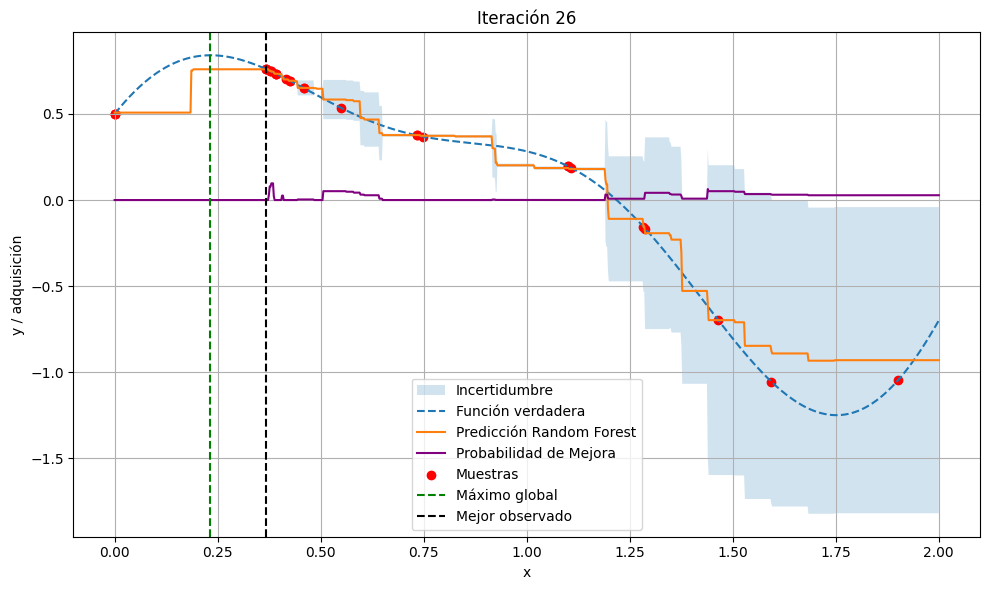

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


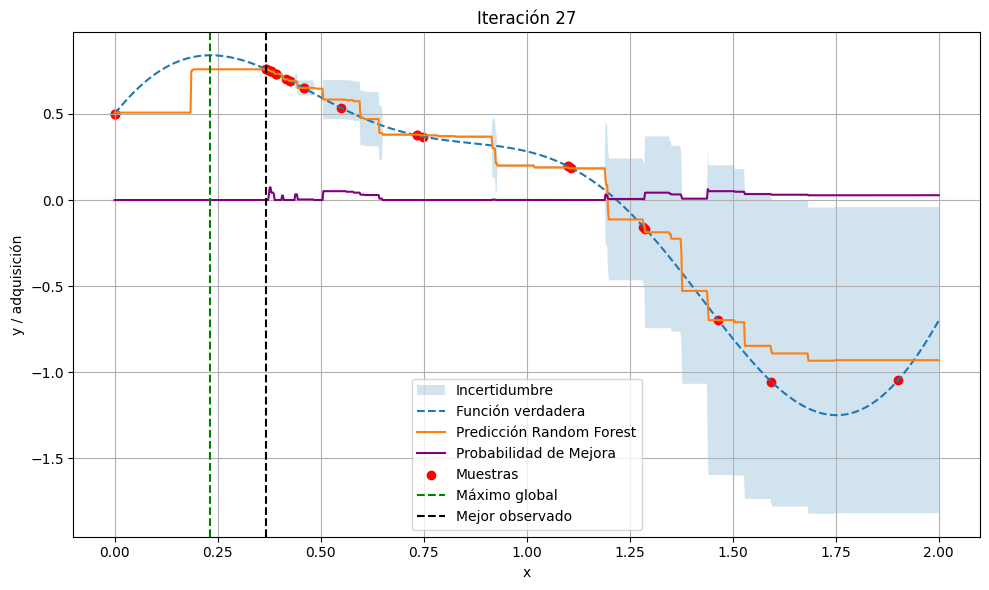

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


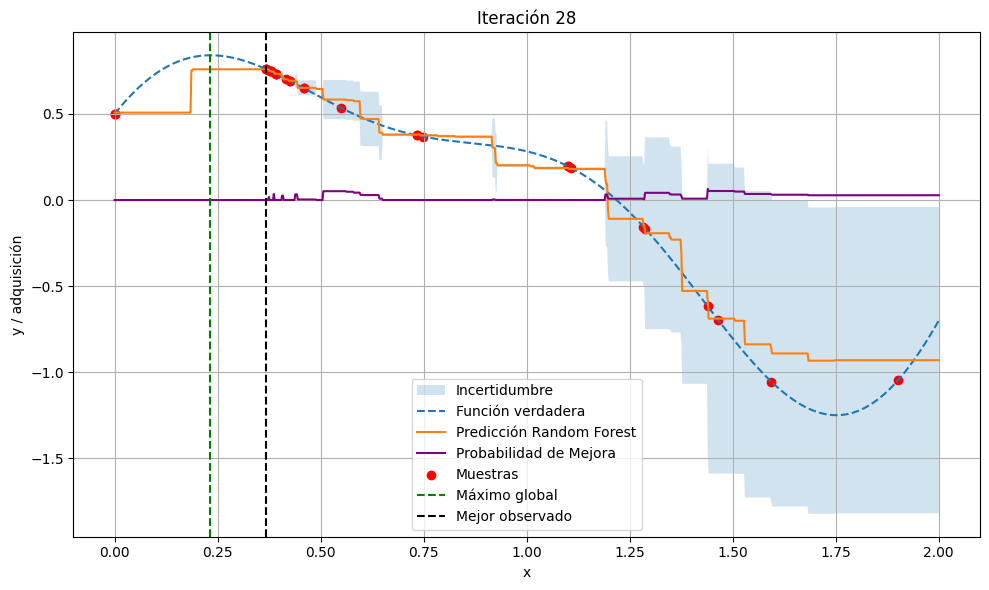

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


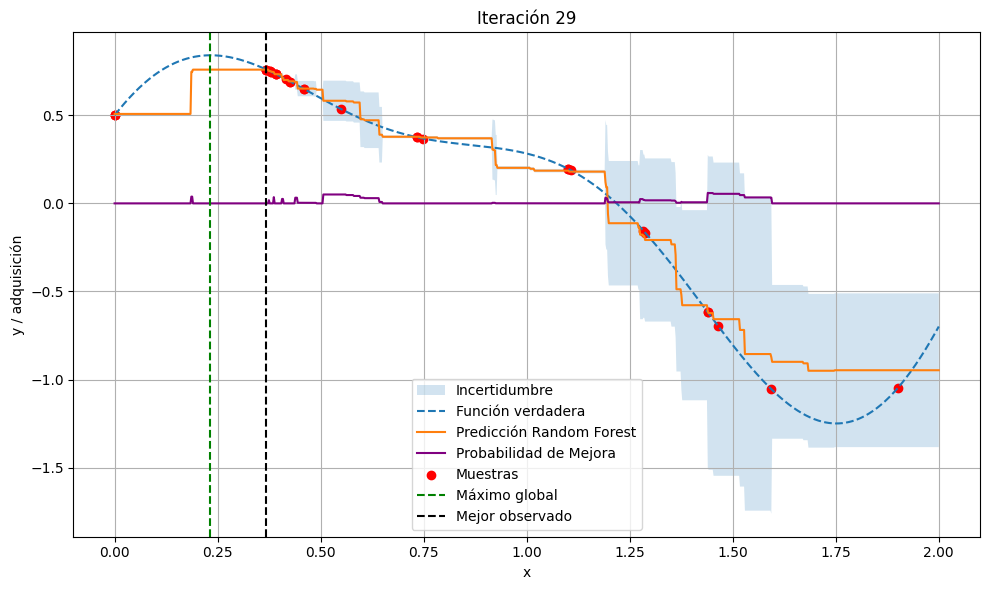

/tmp/ipython-input-25-3899104436.py:30: RuntimeWarning: divide by zero encountered in divide
  Z = (media - mejor_objetivo - xi) / desviacion


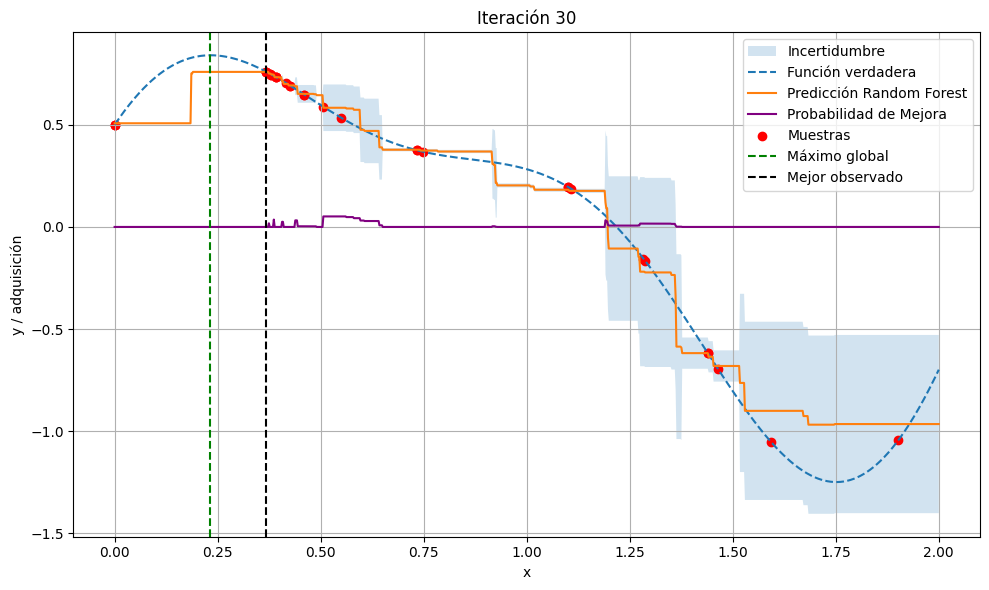

In [ ]:
# ---- Función verdadera (a optimizar) ----
def funcion_objetivo(x):
    return np.sin(3 * x) + 0.5 * np.cos(5 * x)

# ---- Inicialización ----
np.random.seed(42)
limites = np.array([[0, 2]])
X_denso = np.linspace(limites[0, 0], limites[0, 1], 1000).reshape(-1, 1)
y_verdadero = funcion_objetivo(X_denso)

# Muestras iniciales
X_entrenamiento = np.random.uniform(limites[0, 0], limites[0, 1], size=(3, 1))
y_entrenamiento = funcion_objetivo(X_entrenamiento)


# Creamos el modelo de Random Forest con 100 arboles
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# -------------------------------------------------------------------------------------------- Bucle de Aprendizaje Activo con  Probability of IMPROVEMENT---------------------------------------------------------------------------
n_iteraciones = 30
for iteracion in range(n_iteraciones):
    # Ajustar el modelo
    rf_fitted=rf.fit(X_entrenamiento, y_entrenamiento)

    # Predecir
    media_pred, desviacion_pred = rfPredictionUncertainty(rf_fitted, X_denso)
    pi = probabilidad_mejora(X_denso, rf_fitted, np.max(y_entrenamiento))

    # Seleccionar el siguiente punto
    x_siguiente = X_denso[np.argmax(pi)]
    y_siguiente = funcion_objetivo(x_siguiente)

    # Agregar nueva muestra
    X_entrenamiento = np.vstack((X_entrenamiento, x_siguiente))
    y_entrenamiento = np.append(y_entrenamiento, y_siguiente)

    # ---- Graficar ----
    plt.figure(figsize=(10, 6))
    plt.fill_between(X_denso.ravel(), media_pred - desviacion_pred, media_pred + desviacion_pred, alpha=0.2, label='Incertidumbre')
    plt.plot(X_denso, y_verdadero, '--', label='Función verdadera')
    plt.plot(X_denso, media_pred, label='Predicción Random Forest')
    plt.plot(X_denso, pi, label='Probabilidad de Mejora', color='purple')
    plt.scatter(X_entrenamiento, y_entrenamiento, color='red', label='Muestras')
    plt.axvline(X_denso[np.argmax(y_verdadero)], color='green', linestyle='--', label='Máximo global')
    plt.axvline(X_entrenamiento[np.argmax(y_entrenamiento)], color='black', linestyle='--', label='Mejor observado')
    plt.title(f"Iteración {iteracion + 1}")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y / adquisición")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Multiobjetivo

In [ ]:
"""No siempre tendremos las variables con un solo objetivo a veces tendremos mas de una variable de respuesta
   cuando esto pasa necesitamos trabajar las variables como si fueran una sola"""

from scipy.stats import norm

def scalarized_mean_std(X, modelos, w):
    """
    Devuelve la media y desviación de la función objetivo escalar f_t(x)=∑ w_i f_i(x),
    asumiendo independencia entre modelos para combinar varianzas.

    Parámetros
    ----------
    X : np.ndarray, forma (n_muestras, n_características)
    modelos : list de modelos entrenados
        Cada modelo debe soportar rfPredictionUncertainty(modelo, X) → (media, std)
    w : np.ndarray, forma (n_modelos,)
        Pesos que suman 1.

    Retorna
    -------
    mu_t : np.ndarray, forma (n_muestras,)
    sigma_t : np.ndarray, forma (n_muestras,)
    """
    mus = []
    sig2 = []
    for modelo, wi in zip(modelos, w):
        mu_i, std_i = rfPredictionUncertainty(modelo, X)
        mu_i = mu_i.reshape(-1)
        std_i = std_i.reshape(-1)
        mus.append(wi * mu_i)
        sig2.append((wi * std_i)**2)
    mu_t = np.sum(mus, axis=0)
    sigma_t = np.sqrt(np.sum(sig2, axis=0))
    return mu_t, sigma_t

def pi_scalarizado(X, modelos, w, mejor_scalar, xi=0.01):
    """
    Probabilidad de Mejora sobre la función escalarizada.
    """
    mu_t, sigma_t = scalarized_mean_std(X, modelos, w)
    with np.errstate(divide='warn'):
        Z = (mu_t - mejor_scalar - xi) / sigma_t
        pi = norm.cdf(Z)
        pi[sigma_t == 0.0] = 0.0
    return pi

def ei_scalarizado(X, modelos, w, mejor_scalar, xi=0.01):
    """
    Mejora Esperada sobre la función escalarizada.
    """
    mu_t, sigma_t = scalarized_mean_std(X, modelos, w)
    with np.errstate(divide='warn'):
        improvement = mu_t - mejor_scalar - xi
        Z = improvement / sigma_t
        ei = improvement * norm.cdf(Z) + sigma_t * norm.pdf(Z)
        ei[sigma_t == 0.0] = 0.0
    return ei

def ucb_scalarizado(X, modelos, w, kappa=1.96):
    """
    Upper Confidence Bound sobre la función escalarizada.
    """
    mu_t, sigma_t = scalarized_mean_std(X, modelos, w)
    return mu_t + kappa * sigma_t

# Experimento real

In [ ]:
# Define limites para R, Y, B
bounds = [(10, 300), (10, 300), (10, 300)]
n_init      = 5        # Número de puntos aleatorios iniciales
n_iter      = 25       # Iteraciones BO
n_cand      = 500      # Candidatos a muestrear cada iteración
w           = np.ones(8) / 8    # Pesos uniformes iniciales
student_id  = input("Enter your student ID: ")
verify_student_id(student_id)

# ——— 1) Carga y preparación de tu data inicial ———
exp_df  = pd.read_csv("su_data.csv")
df      = exp_df.apply(extract_data, axis=1)

# Inputs y respuestas
X_obs = df[['R','Y','B']].values                   # shape (n0, 3)
Y_obs = df[['ch583','ch670','ch510','ch410',
            'ch620','ch470','ch550','ch440']].values  # shape (n0, 8)

# ——— 2) Calcular mejor scalar actual ———
f_scalars  = Y_obs.dot(w)            # producto punto fila a fila
best_scalar = np.max(f_scalars)      # si tu objetivo es maximizar

# ——— 3) Entrenar RF independientes para cada respuesta ———
modelos = []
for i in range(Y_obs.shape[1]):
    rf_i = RandomForestRegressor(n_estimators=100, random_state=0)
    rf_i.fit(X_obs, Y_obs[:, i])
    modelos.append(rf_i)

# ——— 4) Loop de Optimización Bayesiana ———
for it in range(n_iter):
    # 4.1) Generar candidatos aleatorios
    low, high = np.array([b[0] for b in bounds]), np.array([b[1] for b in bounds])
    X_cand     = np.random.uniform(low, high, size=(n_cand, 3))

#////////////////////////////////////////////////////////////////////\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
#////////////////////////////////////////////////////////////////////\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# --------------------------ATENCION EN ESTA PARTE. AQUI USTEDES ELEGIRAN SU FUNCION DE ADQUISICION-----------------------------------------------
#////////////////////////////////////////////////////////////////////\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
#////////////////////////////////////////////////////////////////////\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\

    # 4.2) Calcular adquisición (aquí EI; cambia a pi_scalarizado o ucb_scalarizado si prefieres)
    acq_vals = ei_scalarizado(X_cand, modelos, w, best_scalar, xi=0.01)

    # 4.3) Seleccionar el mejor candidato
    idx_next    = np.argmax(acq_vals)
    r_next, y_next, b_next = X_cand[idx_next]

    # 4.4) Enviar experimento y obtener respuestas
    res = submit_experiment(student_id, r_next, y_next, b_next)
    if res is None:
        print(f"Iter {it+1}: experimento falló, saltando iteración.")
        continue

    # 4.5) Añadir el nuevo punto a los observados
    new_row = {'R': r_next, 'Y': y_next, 'B': b_next, **res}
    df      = df.append(new_row, ignore_index=True)
    X_obs   = df[['R','Y','B']].values
    Y_obs   = df[['ch583','ch670','ch510','ch410',
                  'ch620','ch470','ch550','ch440']].values

    # 4.6) Actualizar best_scalar
    f_scalars   = Y_obs.dot(w)
    best_scalar = np.max(f_scalars)

    # 4.7) Re-entrenar cada RF con los datos actualizados
    for i, rf_i in enumerate(modelos):
        rf_i.fit(X_obs, Y_obs[:, i])

    print(f"Iter {it+1}/{n_iter} completada. Best scalar = {best_scalar:.4f}")

# ——— 5) Guardar resultados finales ———
df.to_csv("resultados_de_optimizacion.csv", index=False)
print("Optimización completada. Resultados en 'resultados_de_optimizacion.csv'.")